# Predicting Power Generation and Distribution in Nigeria

In this project, we will strive to predict the amount of electricity generated by the power generation companies (GenCos) and estimate how this power is distributed among the 11 distribution companies (DisCos) in Nigeria. We will be working with time series data obtained from the Nigerian bureau of statistics (NBS) which contains power generated from 28 GenCos between January 2016 and October 2017.

### Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from itertools import chain

from statsmodels.tsa.api import ExponentialSmoothing, Holt
import statsmodels.api as sm

import numpy.linalg as LA
import warnings

import itertools

### Load Datasets

In [2]:
#Load excel sheets into pandas as dataframes
power_gen = pd.read_excel('1-3 Qtr 2017 POWER.xlsx', sheet_name = 'gen_by_plants') #Power generation data

discos_inv= pd.read_excel('nbs power data/NIGERIAN bulk electricity inoices and payments from gencos to discos and offtakers 2016.xlsx', sheet_name = 'DisCo_inv') #DisCo Invoice amounts 

losses_data = pd.read_excel('losses.xlsx', sheet_name = 'losses')


### Explore GenCos Data

            AES  AFAM IV-V  AFAM VI  ALAOJI NIPP    DELTA    EGBIN  GEREGU  \
2016-01-01    0          0      0.0      5009.21  8754.59  24757.0  2669.4   
2016-01-02    0          0      0.0      5392.89  8378.56  25352.0  2723.8   
2016-01-03    0          0      0.0      5370.20  6905.22  25575.0  2969.6   
2016-01-04    0          0      0.0      5374.81  7635.05  25648.0  3064.2   

            IBOM POWER  GEREGU NIPP  IHOVBOR NIPP     ...      SAPELE  \
2016-01-01     1193.43      2173.62           0.0     ...      2744.7   
2016-01-02     1508.47      2384.06           0.0     ...      1680.8   
2016-01-03     1548.71      1998.16           0.0     ...         0.0   
2016-01-04     1684.31      2152.92           0.0     ...         0.0   

            SAPELE NIPP  SHIRORO  TRANS AMADI  ASCO  GBARAIN  ODUKPANI  PARAS  \
2016-01-01          0.0   7201.0          0.0     0      0.0    1564.6    0.0   
2016-01-02          0.0   5751.0          0.0     0      0.0     579.9    0.0   


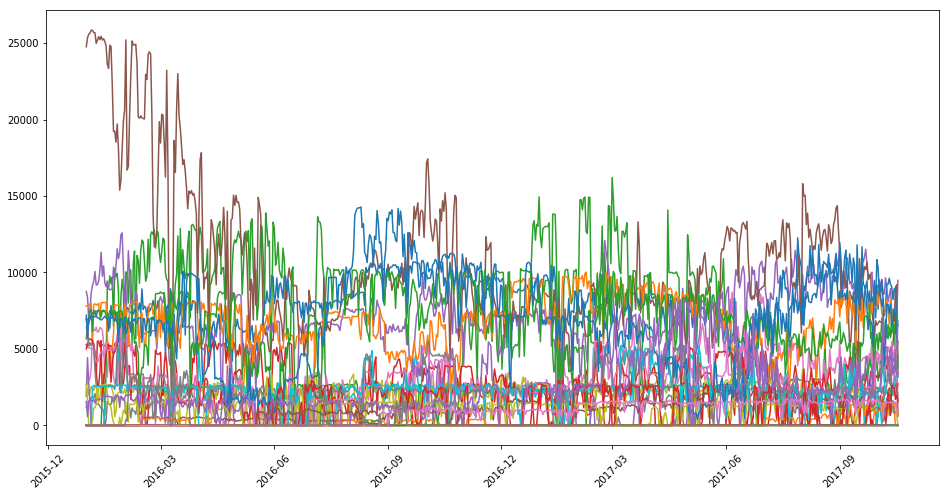

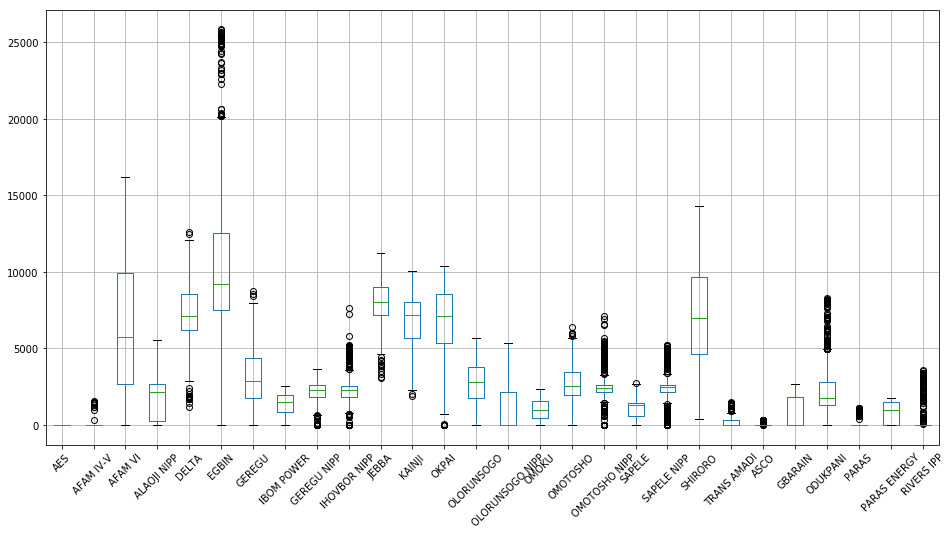

In [4]:
#Exploring GenCos dataframe
print (power_gen.head(4))
print (power_gen.info())
print (power_gen.tail(4))
print (power_gen.describe())

plt.figure(figsize=(16,8))
#Plot daily electricity generated 
plt.plot(power_gen)
plt.xticks(rotation = 45)
plt.show()

#Boxplots
plt.figure(figsize=(16,8))
power_gen.boxplot()
plt.xticks(rotation = 45)
plt.show()

Nine Gencos had to be dropped because they did not generate any electricity in the period or then had extended periods where electricity was not generated. This has made them unpredictable.

In [5]:
auto_arima_results_dropped = {'GEREGU NIPP':(4,1,1),'OKPAI':(1,1,3),'SAPELE':(4,0,3),'ODUKPANI':(4,1,3),'ASCO':(2,0,5),'PARAS':(1,1,1),'RIVERS IPP':(4,1,1),'AES':(1,1,1),'AFAM IV-V':(1,1,0)}

## Model : ARIMA

ARIMA, which stands for Auto-regressive (AR) Integrated (I) Moving Average (MA), is a popular and widely used model for time series analysis and forecasting. Read more about ARIMA models here. 
ARIMA models take three parameters (p,d,q) for each of its components. p for Auto regression as it uses the dependent relationship between an observation and some number of lagged observations. d for the integrated which means the use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary. q for the moving average component uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.




The electricity data for each GenCo is divided into 70% training set and 30% test set to help check the accuracy of our model. This led to minor tweaks especially in the MA component of some of our model parameters.

In [3]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 30)
SARIMAX: (0, 0, 1) x (0, 1, 0, 30)
SARIMAX: (0, 1, 0) x (0, 1, 1, 30)
SARIMAX: (0, 1, 0) x (1, 0, 0, 30)


In [4]:
genco_params = {}  

In [5]:
valid_gencos = ['AFAM VI','ALAOJI NIPP','DELTA','EGBIN','GEREGU','IBOM POWER','IHOVBOR NIPP','KAINJI','OLORUNSOGO','OLORUNSOGO NIPP','OMOKU','JEBBA','OMOTOSHO','OMOTOSHO NIPP','SAPELE NIPP','SHIRORO','TRANS AMADI','GBARAIN','PARAS ENERGY']

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
 

for key in valid_gencos:
    print (key)
    lowest_aic = 1000000

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            mod = sm.tsa.statespace.SARIMAX(power_gen[key],order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)

            results = mod.fit()

            print(param, param_seasonal, results.aic)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                lowest_param = param
                lowest_param_seasonal = param_seasonal
                #print (lowest_param, lowest_param_seasonal, lowest_aic)

            
    
    print ('ARIMA{}x{}30 - AIC:{}'.format(lowest_param, lowest_param_seasonal, lowest_aic))
    genco_params[key] = (lowest_param, lowest_param_seasonal)
    print ('*****************************************************')
            


AFAM VI
(0, 0, 0) (0, 0, 0, 30) 13575.065096235801
(0, 0, 0) (0, 0, 1, 30) 12669.417822324807
(0, 0, 0) (0, 1, 0, 30) 12323.683318080564
(0, 0, 0) (0, 1, 1, 30) 11645.860167613606
(0, 0, 0) (1, 0, 0, 30) 12285.715900497162
(0, 0, 0) (1, 0, 1, 30) 12256.384754395585
(0, 0, 0) (1, 1, 0, 30) 11653.82248889495
(0, 0, 0) (1, 1, 1, 30) 11634.42195331589
(0, 0, 1) (0, 0, 0, 30) 13116.480374891707
(0, 0, 1) (0, 0, 1, 30) 12446.805564738268
(0, 0, 1) (0, 1, 0, 30) 11953.035897199226
(0, 0, 1) (0, 1, 1, 30) 11308.308805341236
(0, 0, 1) (1, 0, 0, 30) 11856.04335866744
(0, 0, 1) (1, 0, 1, 30) 11793.609415717707
(0, 0, 1) (1, 1, 0, 30) 11249.594266777642
(0, 0, 1) (1, 1, 1, 30) 11142.882464811195
(0, 1, 0) (0, 0, 0, 30) 11716.819562568144
(0, 1, 0) (0, 0, 1, 30) 11173.747767693832
(0, 1, 0) (0, 1, 0, 30) 11638.470413552695
(0, 1, 0) (0, 1, 1, 30) 10657.752539333113
(0, 1, 0) (1, 0, 0, 30) 11194.740018670722
(0, 1, 0) (1, 0, 1, 30) 11172.95934160754
(0, 1, 0) (1, 1, 0, 30) 10884.245158122358
(0, 1, 

(1, 1, 1) (0, 1, 1, 30) 9847.566140995907
(1, 1, 1) (1, 0, 0, 30) 10292.112487448172
(1, 1, 1) (1, 0, 1, 30) 10278.80870967589
(1, 1, 1) (1, 1, 0, 30) 10066.738918974188
(1, 1, 1) (1, 1, 1, 30) 9849.455388631264
ARIMA(1, 1, 1)x(0, 1, 1, 30)30 - AIC:9847.566140995907
*****************************************************
EGBIN
(0, 0, 0) (0, 0, 0, 30) 14149.836472347688
(0, 0, 0) (0, 0, 1, 30) 12938.990890691573
(0, 0, 0) (0, 1, 0, 30) 12172.148525993394
(0, 0, 0) (0, 1, 1, 30) 11443.671849965875
(0, 0, 0) (1, 0, 0, 30) 12074.401367181463
(0, 0, 0) (1, 0, 1, 30) 12060.027859934757
(0, 0, 0) (1, 1, 0, 30) 11588.110732330759
(0, 0, 0) (1, 1, 1, 30) 11346.97426640624
(0, 0, 1) (0, 0, 0, 30) 13652.238017608463
(0, 0, 1) (0, 0, 1, 30) 12915.17327224019
(0, 0, 1) (0, 1, 0, 30) 11747.811996242532
(0, 0, 1) (0, 1, 1, 30) 11079.942901348852
(0, 0, 1) (1, 0, 0, 30) 11660.629279675093
(0, 0, 1) (1, 0, 1, 30) 11603.023134189993
(0, 0, 1) (1, 1, 0, 30) 11171.701559802066
(0, 0, 1) (1, 1, 1, 30) 11055.

(1, 1, 0) (1, 0, 0, 30) 9176.717249820129
(1, 1, 0) (1, 0, 1, 30) 9178.715180518346
(1, 1, 0) (1, 1, 0, 30) 9002.053515833635
(1, 1, 0) (1, 1, 1, 30) 8805.893108439977
(1, 1, 1) (0, 0, 0, 30) 9553.68087178464
(1, 1, 1) (0, 0, 1, 30) 9106.832015218237
(1, 1, 1) (0, 1, 0, 30) 9575.895676707543
(1, 1, 1) (0, 1, 1, 30) 8743.185928103485
(1, 1, 1) (1, 0, 0, 30) 9126.012113371662
(1, 1, 1) (1, 0, 1, 30) 9109.16095070602
(1, 1, 1) (1, 1, 0, 30) 8950.091028499077
(1, 1, 1) (1, 1, 1, 30) 8743.819752357133
ARIMA(1, 1, 1)x(0, 1, 1, 30)30 - AIC:8743.185928103485
*****************************************************
IHOVBOR NIPP
(0, 0, 0) (0, 0, 0, 30) 12107.538958347734
(0, 0, 0) (0, 0, 1, 30) 11224.653968706629
(0, 0, 0) (0, 1, 0, 30) 10935.762956351875
(0, 0, 0) (0, 1, 1, 30) 10029.458841085634
(0, 0, 0) (1, 0, 0, 30) 10911.824414555682
(0, 0, 0) (1, 0, 1, 30) 10651.545529567142
(0, 0, 0) (1, 1, 0, 30) 10184.568938353113
(0, 0, 0) (1, 1, 1, 30) 10028.525060657117
(0, 0, 1) (0, 0, 0, 30) 11398.26

(1, 0, 1) (1, 0, 1, 30) 9939.158766212839
(1, 0, 1) (1, 1, 0, 30) 9673.104950319048
(1, 0, 1) (1, 1, 1, 30) 9508.732888076396
(1, 1, 0) (0, 0, 0, 30) 10480.619330399244
(1, 1, 0) (0, 0, 1, 30) 9942.406128203009
(1, 1, 0) (0, 1, 0, 30) 10406.876147590485
(1, 1, 0) (0, 1, 1, 30) 9545.50032694987
(1, 1, 0) (1, 0, 0, 30) 9942.442598811762
(1, 1, 0) (1, 0, 1, 30) 9944.158090223278
(1, 1, 0) (1, 1, 0, 30) 9705.25944045732
(1, 1, 0) (1, 1, 1, 30) 9546.883753823597
(1, 1, 1) (0, 0, 0, 30) 10401.202467887195
(1, 1, 1) (0, 0, 1, 30) 9863.988142363763
(1, 1, 1) (0, 1, 0, 30) 10314.220539994847
(1, 1, 1) (0, 1, 1, 30) 9478.934723436108
(1, 1, 1) (1, 0, 0, 30) 9893.6895086035
(1, 1, 1) (1, 0, 1, 30) 9862.456285887525
(1, 1, 1) (1, 1, 0, 30) 9636.315354480234
(1, 1, 1) (1, 1, 1, 30) 9480.758241694162
ARIMA(1, 1, 1)x(0, 1, 1, 30)30 - AIC:9478.934723436108
*****************************************************
OLORUNSOGO NIPP
(0, 0, 0) (0, 0, 0, 30) 11632.77054913513
(0, 0, 0) (0, 0, 1, 30) 10958.37523

(1, 0, 1) (0, 0, 0, 30) 10634.963148663557
(1, 0, 1) (0, 0, 1, 30) 10174.32067300933
(1, 0, 1) (0, 1, 0, 30) 10537.507468929682
(1, 0, 1) (0, 1, 1, 30) 9755.883327053689
(1, 0, 1) (1, 0, 0, 30) 10189.599817595008
(1, 0, 1) (1, 0, 1, 30) 10176.046687930688
(1, 0, 1) (1, 1, 0, 30) 9900.814702525722
(1, 0, 1) (1, 1, 1, 30) 9757.524810621384
(1, 1, 0) (0, 0, 0, 30) 10666.255069815086
(1, 1, 0) (0, 0, 1, 30) 10204.352684360285
(1, 1, 0) (0, 1, 0, 30) 10598.283295654292
(1, 1, 0) (0, 1, 1, 30) 9795.255319890239
(1, 1, 0) (1, 0, 0, 30) 10204.26766783083
(1, 1, 0) (1, 0, 1, 30) 10206.05984814619
(1, 1, 0) (1, 1, 0, 30) 9935.59774217394
(1, 1, 0) (1, 1, 1, 30) 9797.254598065083
(1, 1, 1) (0, 0, 0, 30) 10607.652234270627
(1, 1, 1) (0, 0, 1, 30) 10147.666805017472
(1, 1, 1) (0, 1, 0, 30) 10544.01017279024
(1, 1, 1) (0, 1, 1, 30) 9740.80783593006
(1, 1, 1) (1, 0, 0, 30) 10162.994415468638
(1, 1, 1) (1, 0, 1, 30) 10149.525509628775
(1, 1, 1) (1, 1, 0, 30) 9896.307114422394
(1, 1, 1) (1, 1, 1, 30) 9

(1, 0, 0) (0, 1, 0, 30) 10184.857854487116
(1, 0, 0) (0, 1, 1, 30) 9381.280006693805
(1, 0, 0) (1, 0, 0, 30) 9804.808336413153
(1, 0, 0) (1, 0, 1, 30) 9806.211364958584
(1, 0, 0) (1, 1, 0, 30) 9582.302832264393
(1, 0, 0) (1, 1, 1, 30) 9382.917415161744
(1, 0, 1) (0, 0, 0, 30) 10229.674053235844
(1, 0, 1) (0, 0, 1, 30) 9772.493833199816
(1, 0, 1) (0, 1, 0, 30) 10165.536525273019
(1, 0, 1) (0, 1, 1, 30) 9364.402408904718
(1, 0, 1) (1, 0, 0, 30) 9787.312098883758
(1, 0, 1) (1, 0, 1, 30) 9774.203723518314
(1, 0, 1) (1, 1, 0, 30) 9579.828626708038
(1, 0, 1) (1, 1, 1, 30) 9366.060908717353
(1, 1, 0) (0, 0, 0, 30) 10240.267572889446
(1, 1, 0) (0, 0, 1, 30) 9783.246614700056
(1, 1, 0) (0, 1, 0, 30) 10224.50434874503
(1, 1, 0) (0, 1, 1, 30) 9406.528182271408
(1, 1, 0) (1, 0, 0, 30) 9783.574958186244
(1, 1, 0) (1, 0, 1, 30) 9784.758777586132
(1, 1, 0) (1, 1, 0, 30) 9610.641938476034
(1, 1, 0) (1, 1, 1, 30) 9407.657394548221
(1, 1, 1) (0, 0, 0, 30) 10184.627872960591
(1, 1, 1) (0, 0, 1, 30) 9730.

(0, 1, 1) (1, 0, 0, 30) 9696.668148805755
(0, 1, 1) (1, 0, 1, 30) 9669.14530542317
(0, 1, 1) (1, 1, 0, 30) 9498.382745308194
(0, 1, 1) (1, 1, 1, 30) 9286.917238666494
(1, 0, 0) (0, 0, 0, 30) 10100.335067773265
(1, 0, 0) (0, 0, 1, 30) 9670.516228752027
(1, 0, 0) (0, 1, 0, 30) 10066.39139839026
(1, 0, 0) (0, 1, 1, 30) 9276.111952501202
(1, 0, 0) (1, 0, 0, 30) 9669.82171790432
(1, 0, 0) (1, 0, 1, 30) 9672.513127873106
(1, 0, 0) (1, 1, 0, 30) 9456.963264090253
(1, 0, 0) (1, 1, 1, 30) 9278.011282341566
(1, 0, 1) (0, 0, 0, 30) 10087.79285341648
(1, 0, 1) (0, 0, 1, 30) 9657.866577096967
(1, 0, 1) (0, 1, 0, 30) 10051.416346828584
(1, 0, 1) (0, 1, 1, 30) 9263.399112907164
(1, 0, 1) (1, 0, 0, 30) 9672.26023365332
(1, 0, 1) (1, 0, 1, 30) 9659.864458997206
(1, 0, 1) (1, 1, 0, 30) 9456.154208631277
(1, 0, 1) (1, 1, 1, 30) 9265.308667754318
(1, 1, 0) (0, 0, 0, 30) 10113.977226709809
(1, 1, 0) (0, 0, 1, 30) 9682.84706656477
(1, 1, 0) (0, 1, 0, 30) 10099.843669836617
(1, 1, 0) (0, 1, 1, 30) 9300.32849

In [7]:
sarimax_results = {}
for genco,p in genco_params.items():
    print (genco)
    mod = sm.tsa.statespace.SARIMAX(power_gen[genco],order=p[0],seasonal_order=p[1],enforce_stationarity=False,enforce_invertibility=False)

    results = mod.fit()
    
    sarimax_results[genco] = results

    print(results.summary().tables[1])
    
    

AFAM VI
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7568      0.042     17.990      0.000       0.674       0.839
ma.L1         -0.9170      0.033    -28.100      0.000      -0.981      -0.853
ma.S.L30      -1.0297      0.093    -11.078      0.000      -1.212      -0.847
sigma2      2.998e+06   3.24e+05      9.245      0.000    2.36e+06    3.63e+06
ALAOJI NIPP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6466      0.056     11.530      0.000       0.537       0.757
ma.L1         -1.1785      0.057    -20.606      0.000      -1.291      -1.066
ma.S.L30      -1.0028      0.714     -1.404      0.160      -2.403       0.397
sigma2      3.846e+05    2.8e+05      1.375      0.169   -1.64e+05    9.33e+05
DELTA
                 coef    s

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7850      0.024     32.495      0.000       0.738       0.832
ma.L1          0.1908      0.040      4.742      0.000       0.112       0.270
ar.S.L30       0.0650      0.037      1.749      0.080      -0.008       0.138
ma.S.L30      -0.9733      0.116     -8.407      0.000      -1.200      -0.746
sigma2      3.477e+05    3.6e+04      9.671      0.000    2.77e+05    4.18e+05
SAPELE NIPP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7241      0.031     23.022      0.000       0.662       0.786
ma.L1         -1.0618      0.017    -61.405      0.000      -1.096      -1.028
ma.S.L30      -1.0011      0.048    -20.764      0.000      -1.096      -0.907
sigma2      3.149e+05   1.52e-07   2.07e

AFAM VI


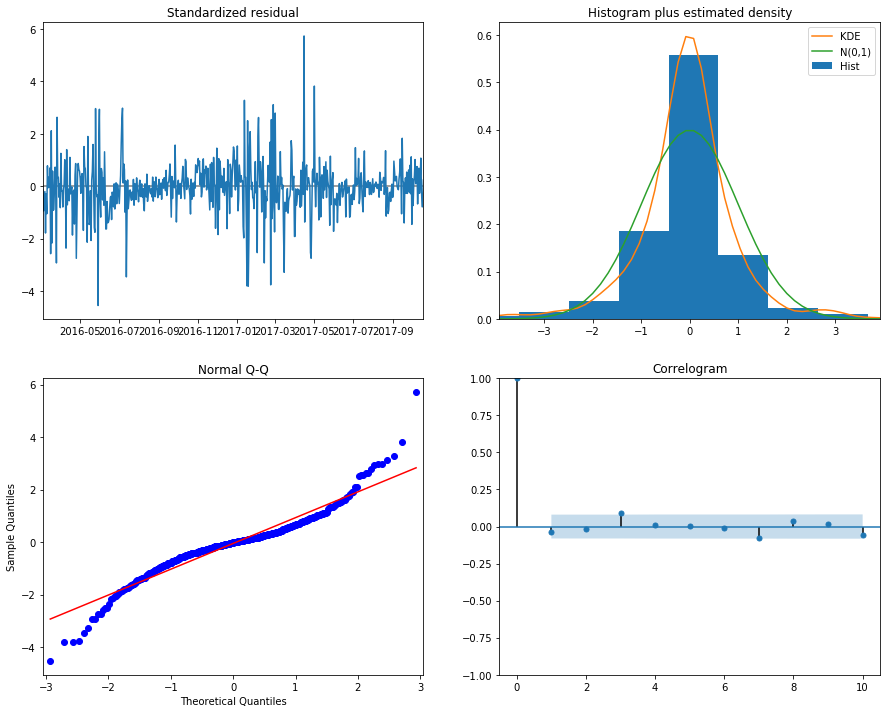

ALAOJI NIPP


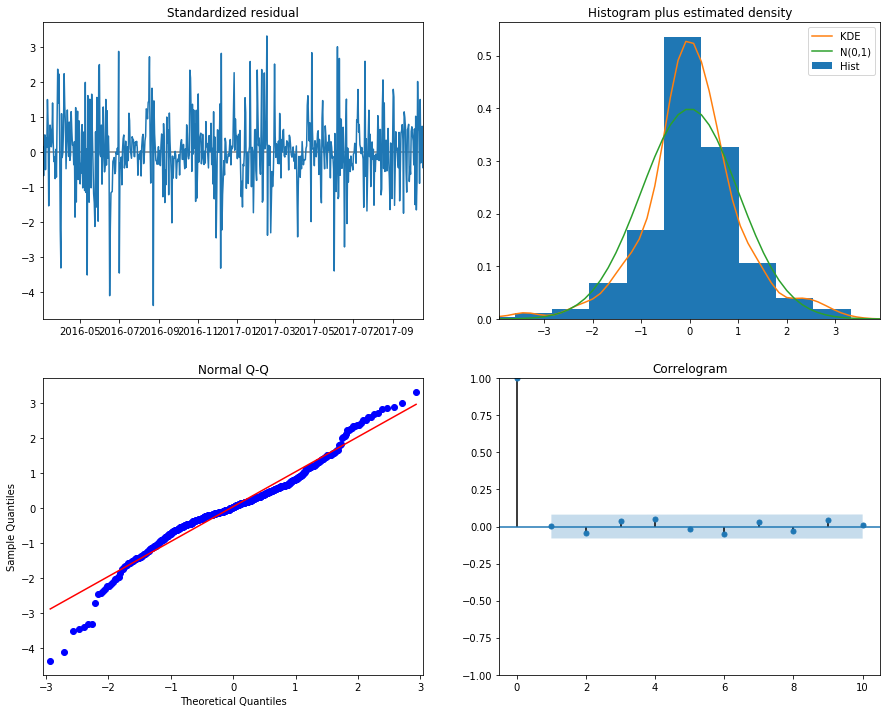

DELTA


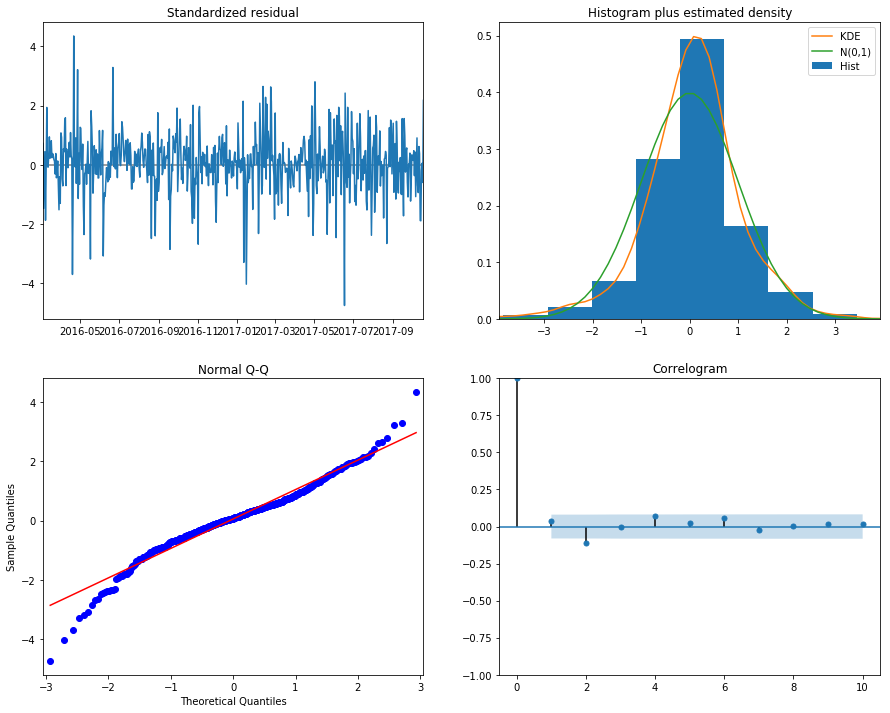

EGBIN


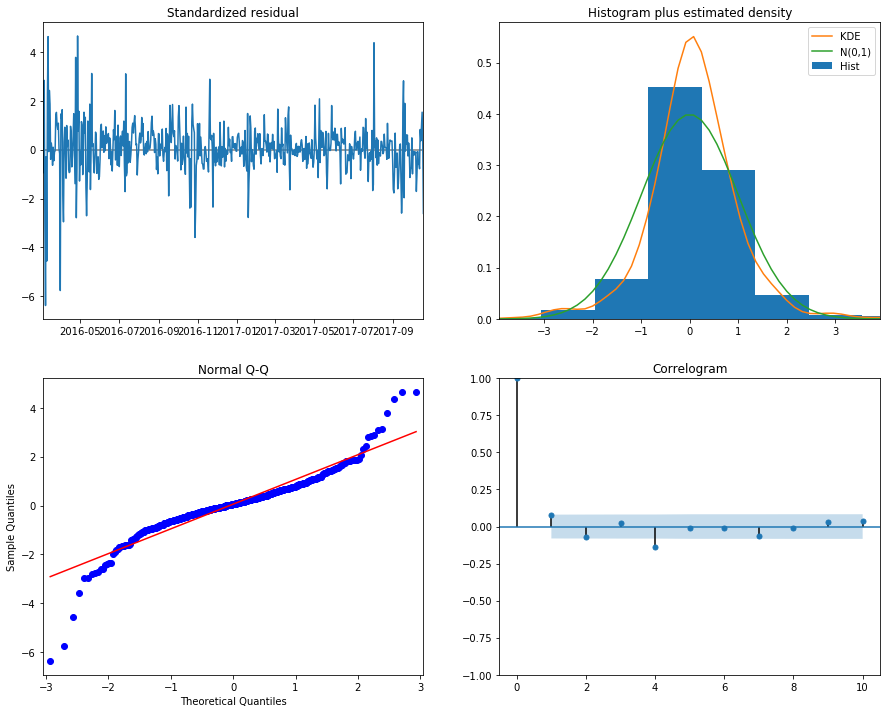

GEREGU


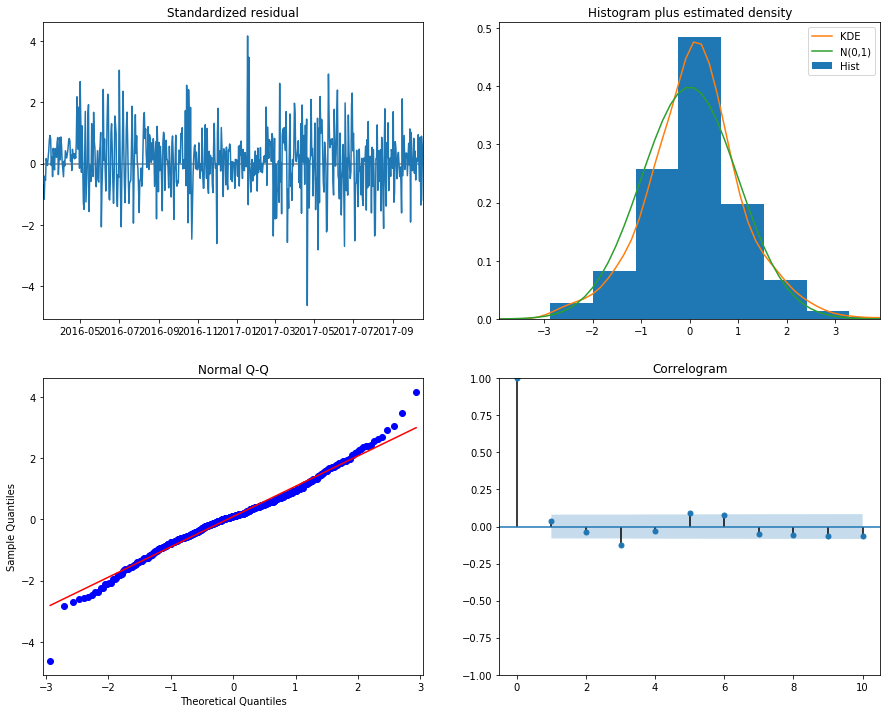

IBOM POWER


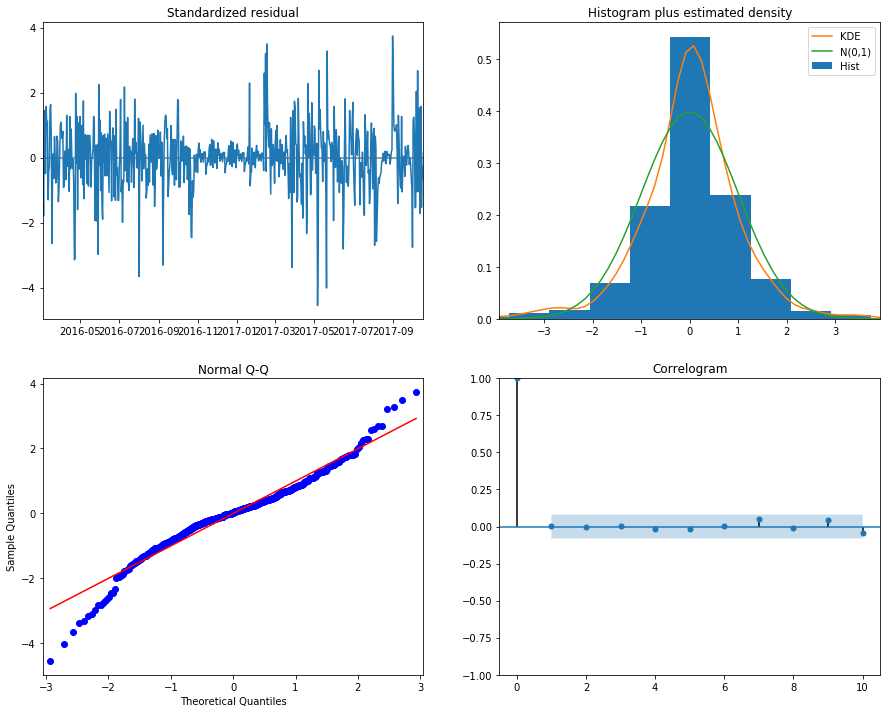

IHOVBOR NIPP


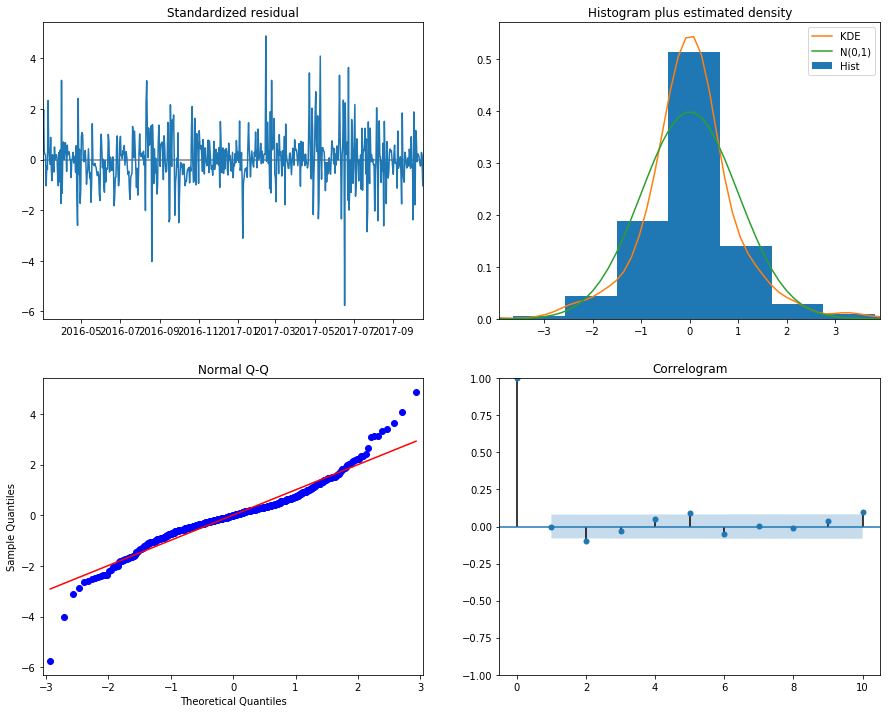

KAINJI


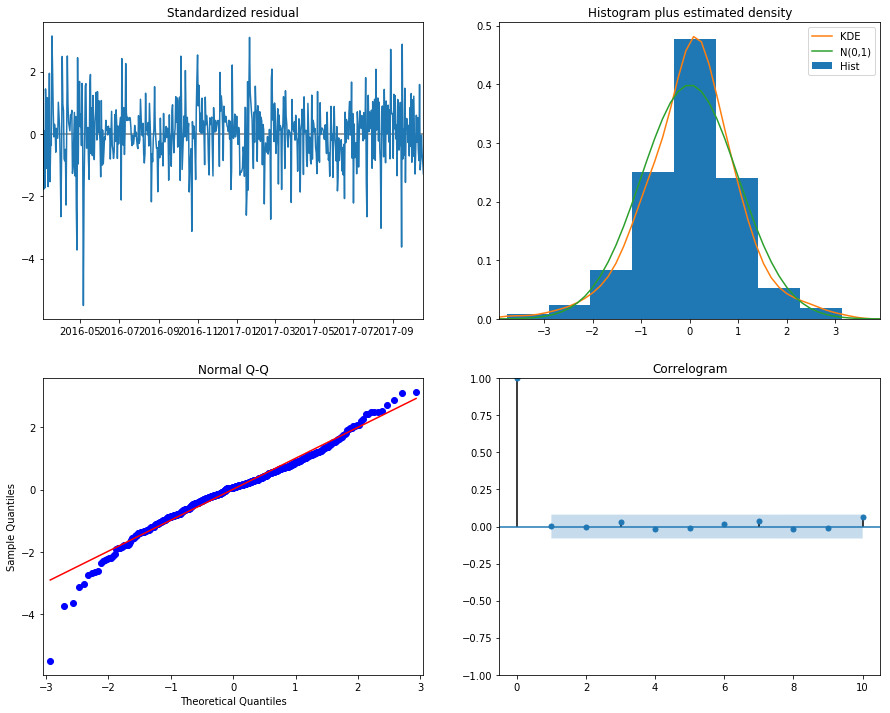

OLORUNSOGO


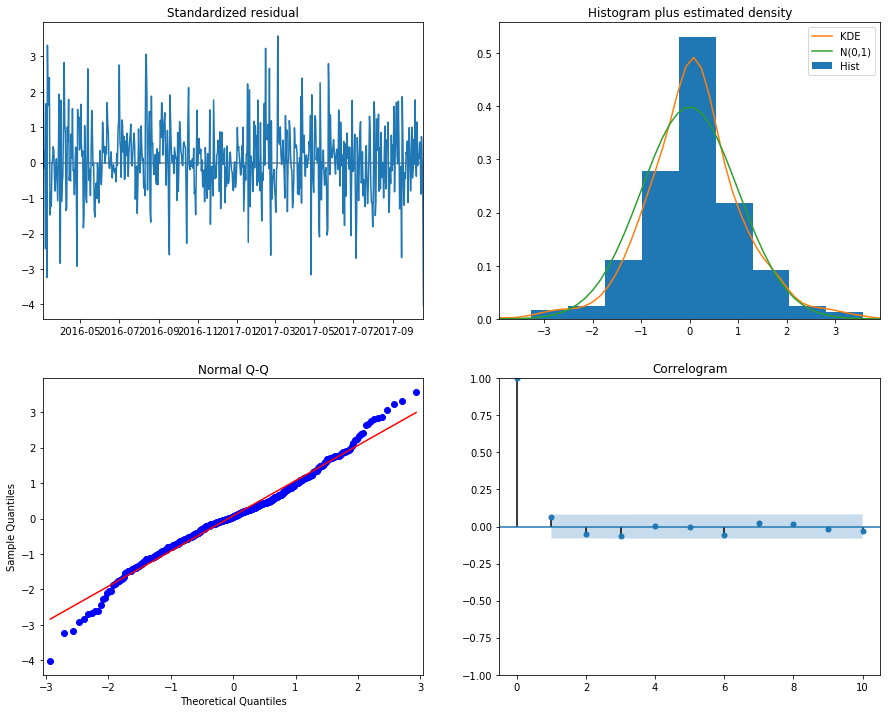

OLORUNSOGO NIPP


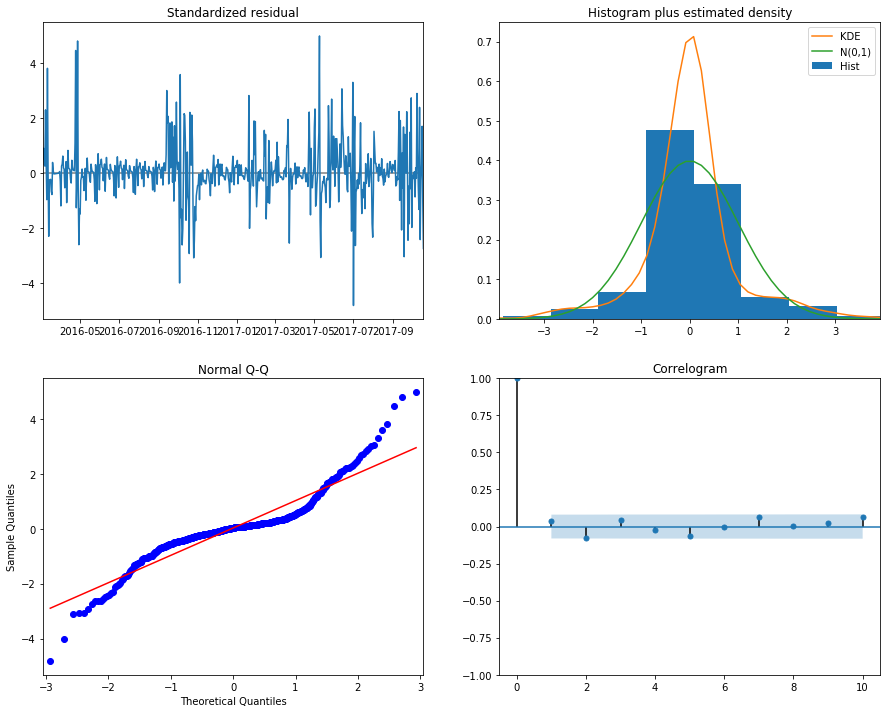

OMOKU


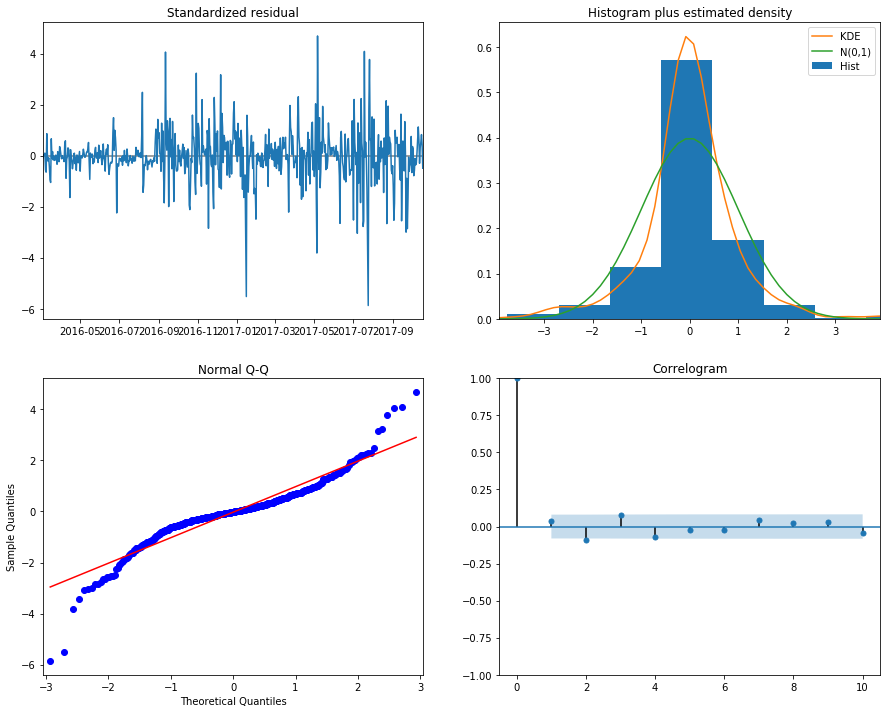

JEBBA


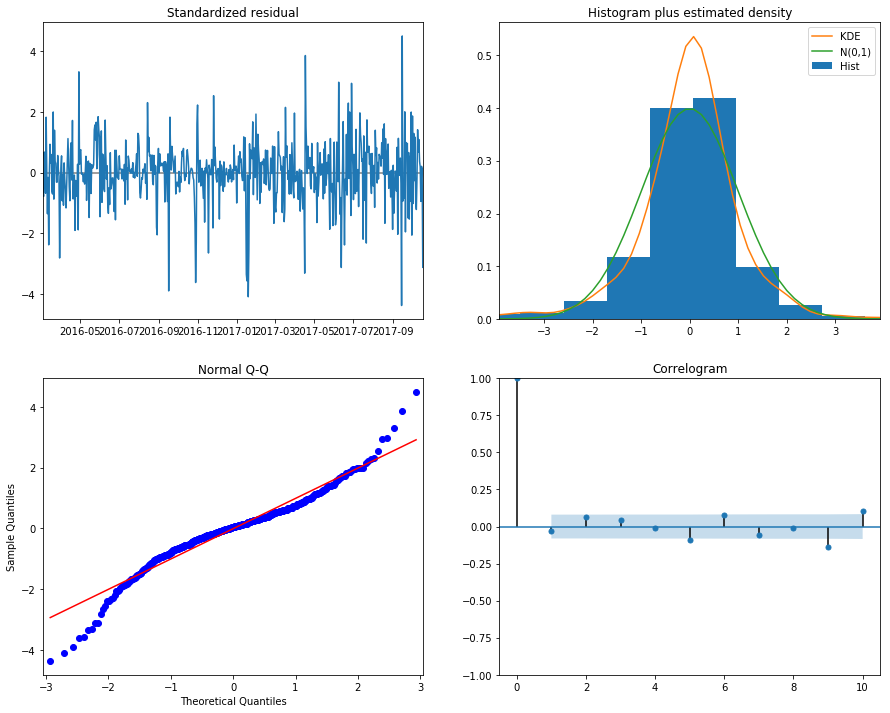

OMOTOSHO


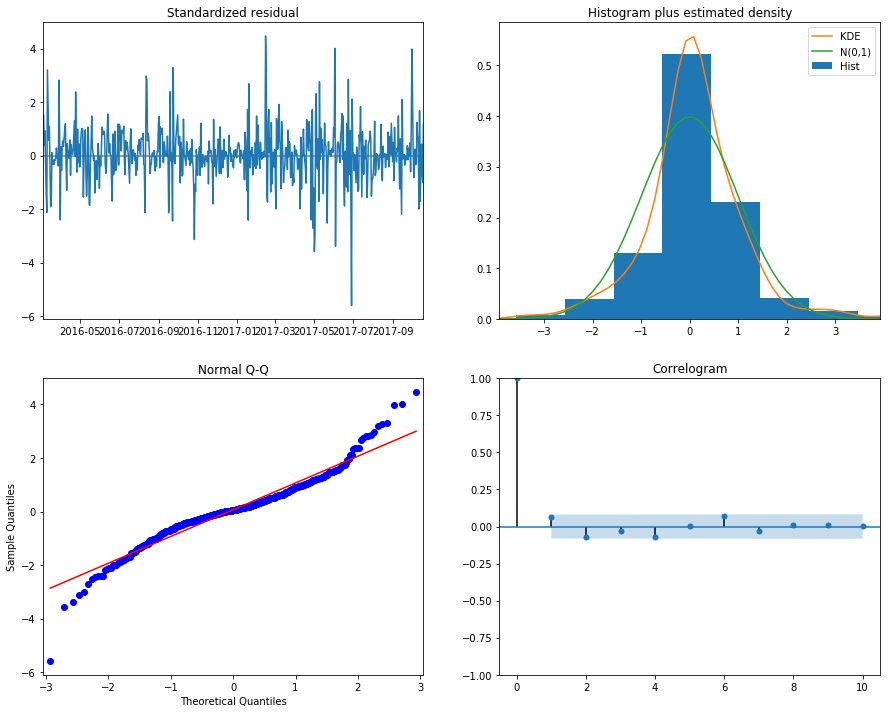

OMOTOSHO NIPP


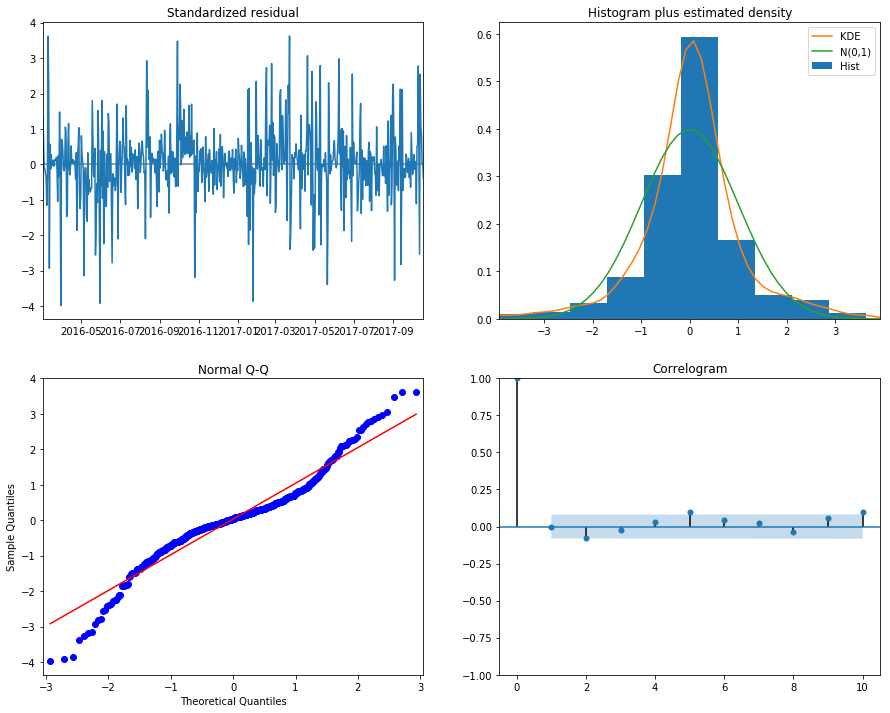

SAPELE NIPP


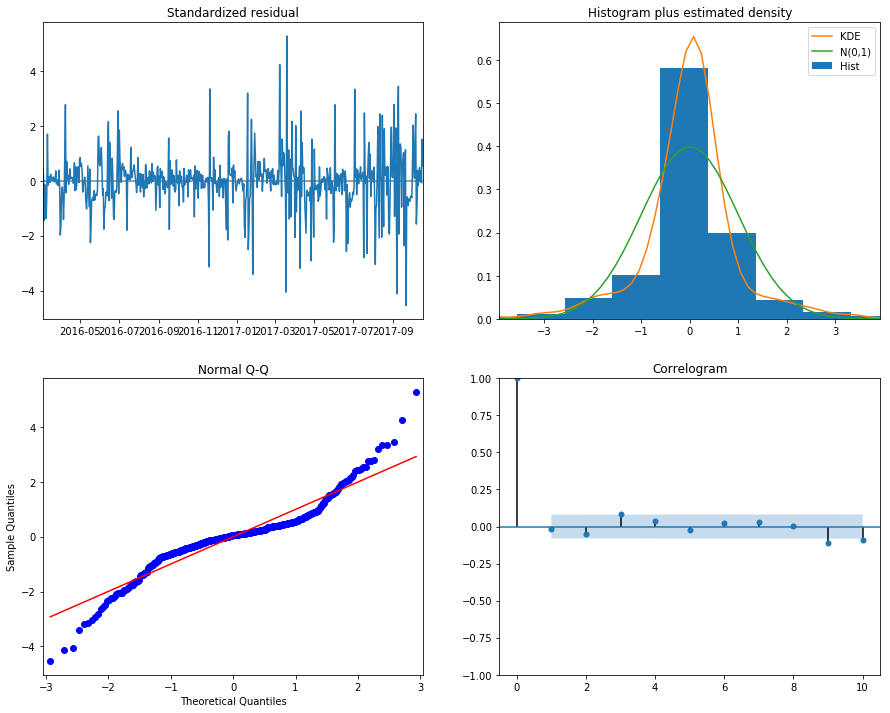

SHIRORO


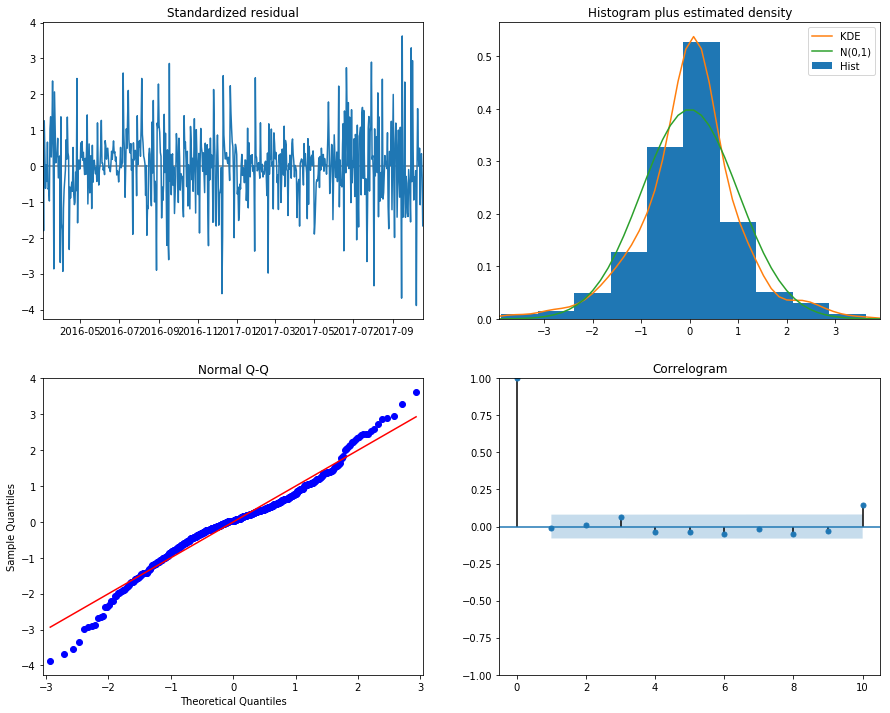

TRANS AMADI


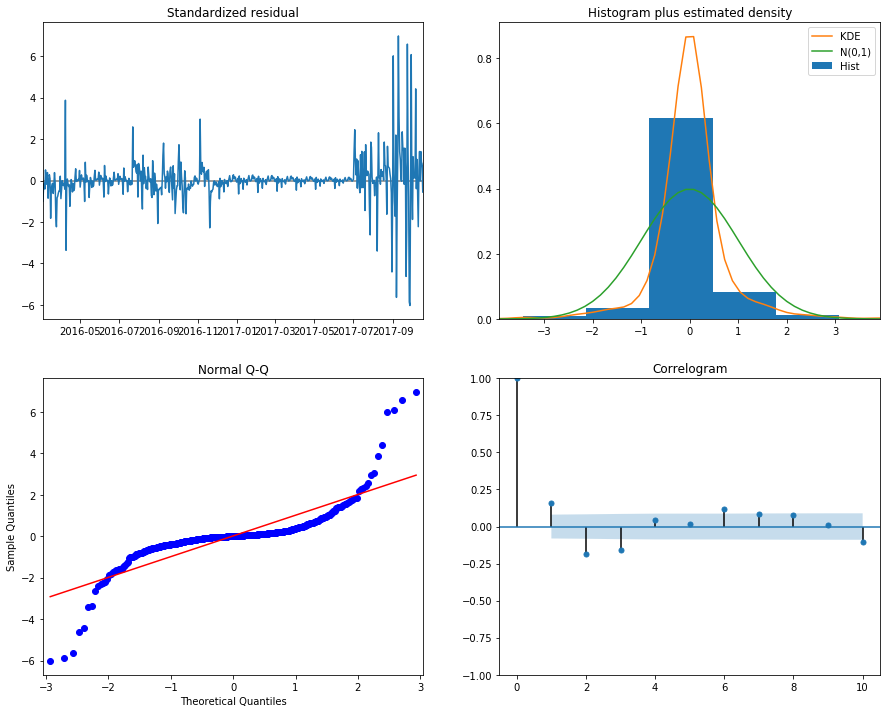

GBARAIN


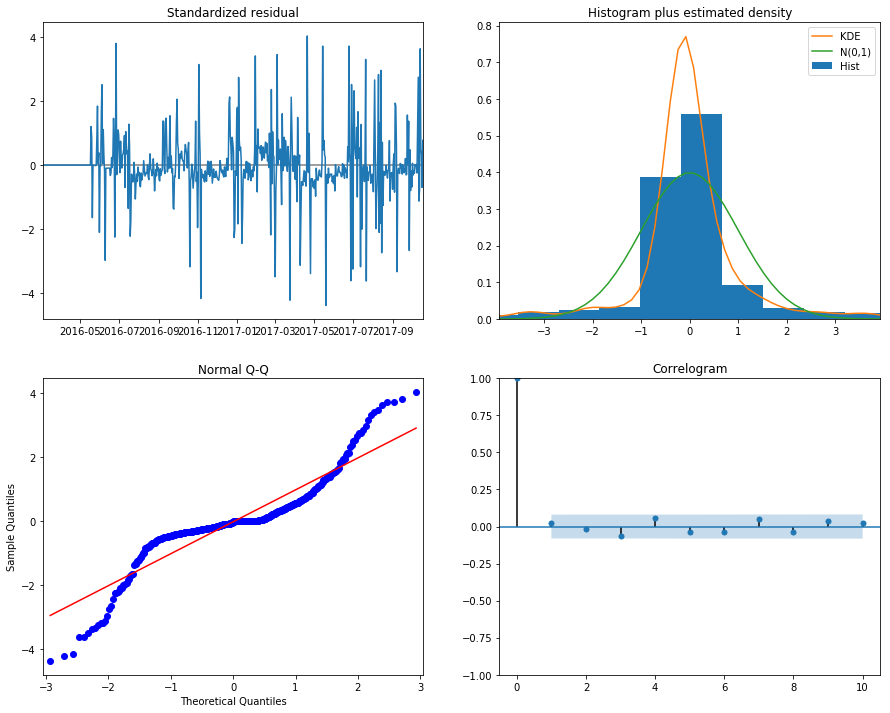

PARAS ENERGY


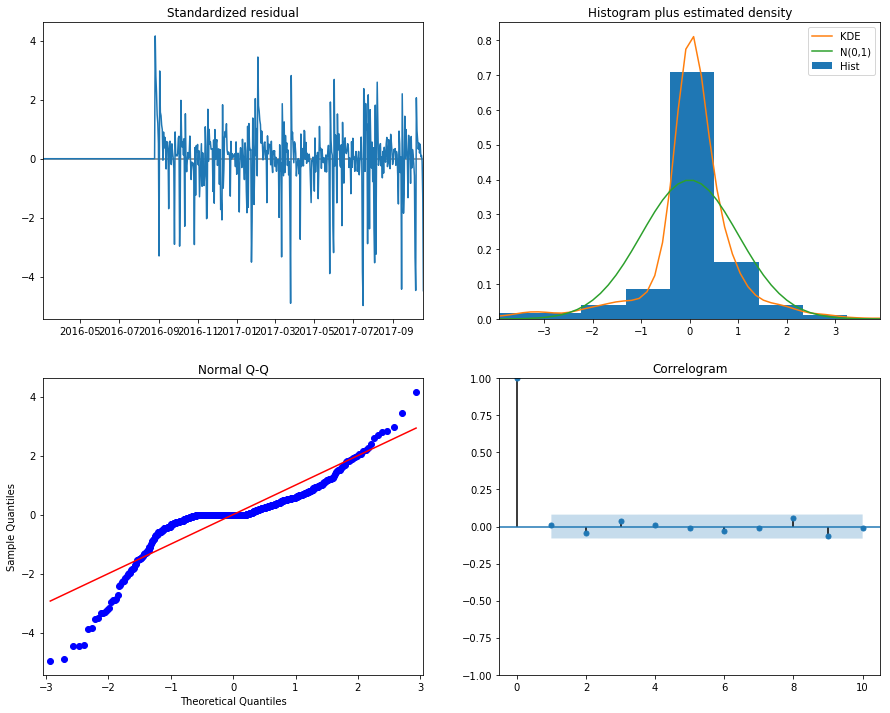

In [8]:
for genco, result in sarimax_results.items():
    print (genco)
    result.plot_diagnostics(figsize=(15, 12))
    plt.show()

In [9]:
predictions ={}
for genco, result in sarimax_results.items():
    #print (genco)
    pred = result.get_prediction(start=pd.to_datetime('2016-04-01'), dynamic=False)
    
    pred_ci = pred.conf_int()
    
    predictions[genco] = (pred,pred_ci)
    

AFAM VI


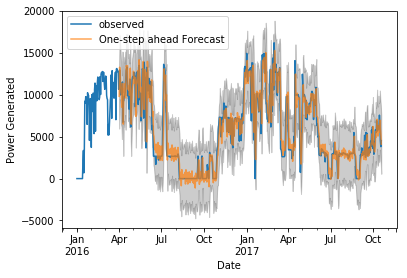

ALAOJI NIPP


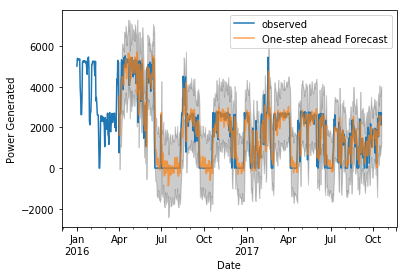

DELTA


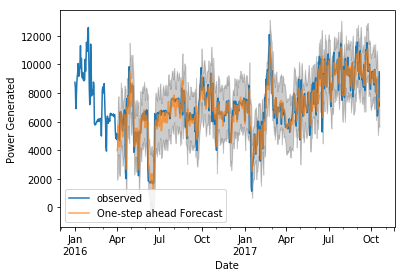

EGBIN


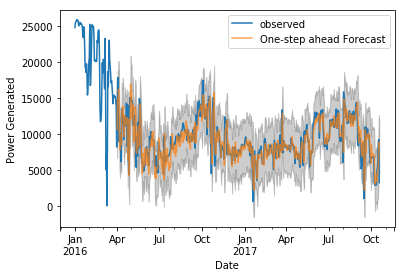

GEREGU


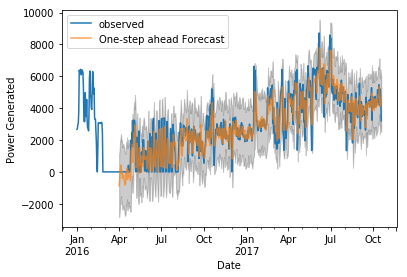

IBOM POWER


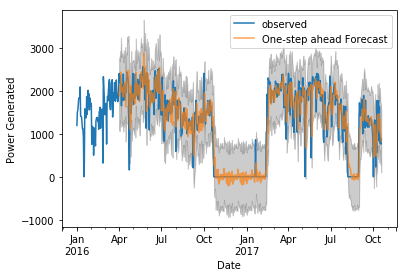

IHOVBOR NIPP


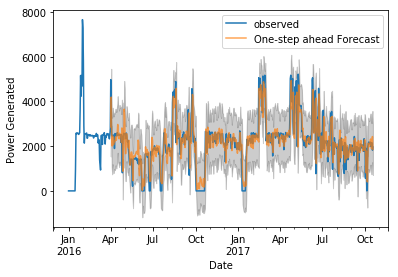

KAINJI


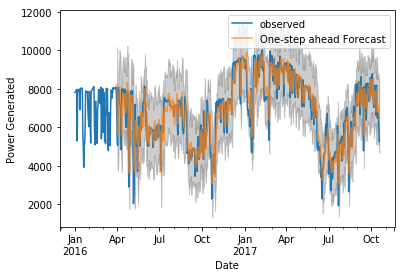

OLORUNSOGO


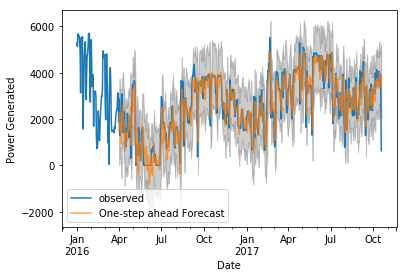

OLORUNSOGO NIPP


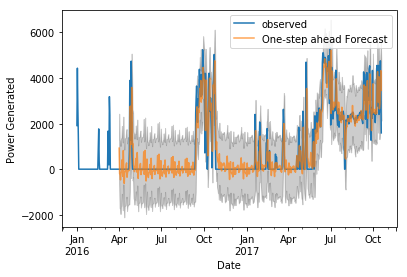

OMOKU


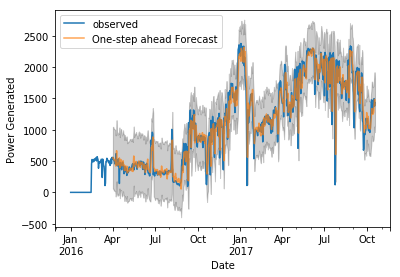

JEBBA


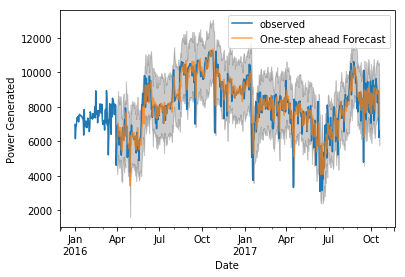

OMOTOSHO


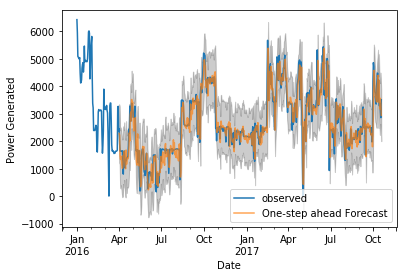

OMOTOSHO NIPP


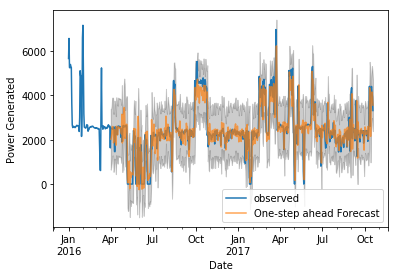

SAPELE NIPP


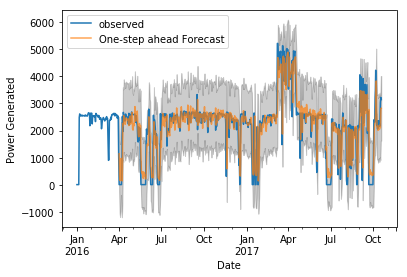

SHIRORO


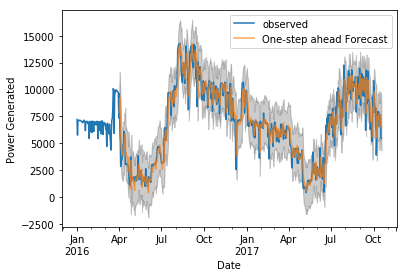

TRANS AMADI


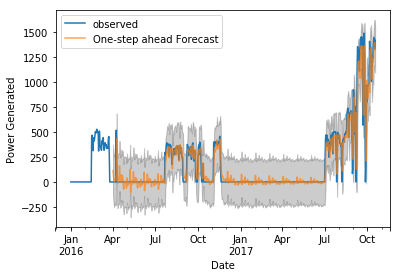

GBARAIN


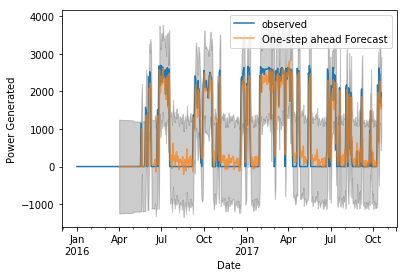

PARAS ENERGY


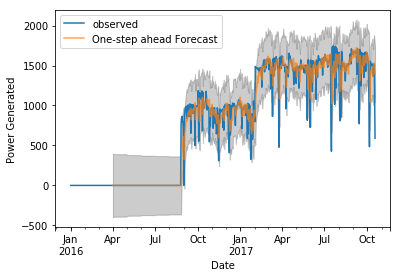

In [13]:
for genco, pred in predictions.items():
    print (genco)
    ax = power_gen[genco].plot(label='observed')
    pred[0].predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred[1].index,pred[1].iloc[:, 0],pred[1].iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Power Generated')
    plt.legend()

    plt.show()

In [14]:
for genco, pred in predictions.items():
    print (genco)
    
    power_forecasted = pred[0].predicted_mean
    power_truth = power_gen[genco]['2017-04-01':]

    # Compute the mean square error
    mse = ((power_forecasted - power_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    

AFAM VI
The Mean Squared Error of our forecasts is 2206839.24
ALAOJI NIPP
The Mean Squared Error of our forecasts is 494566.79
DELTA
The Mean Squared Error of our forecasts is 951732.89
EGBIN
The Mean Squared Error of our forecasts is 2453044.4
GEREGU
The Mean Squared Error of our forecasts is 941837.54
IBOM POWER
The Mean Squared Error of our forecasts is 177913.79
IHOVBOR NIPP
The Mean Squared Error of our forecasts is 454579.33
KAINJI
The Mean Squared Error of our forecasts is 663505.39
OLORUNSOGO
The Mean Squared Error of our forecasts is 470939.53
OLORUNSOGO NIPP
The Mean Squared Error of our forecasts is 650562.73
OMOKU
The Mean Squared Error of our forecasts is 77518.69
JEBBA
The Mean Squared Error of our forecasts is 992809.19
OMOTOSHO
The Mean Squared Error of our forecasts is 311933.74
OMOTOSHO NIPP
The Mean Squared Error of our forecasts is 382614.05
SAPELE NIPP
The Mean Squared Error of our forecasts is 558254.7
SHIRORO
The Mean Squared Error of our forecasts is 1553981.14


### Forecast

In [16]:
predictions_final = {}
for genco, result in sarimax_results.items():
    #print (genco)
    
    # Get forecast 500 steps ahead in future
    pred_uc = result.get_forecast(steps=100)


    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    
    predictions_final[genco] = (pred_uc,pred_ci)

AFAM VI


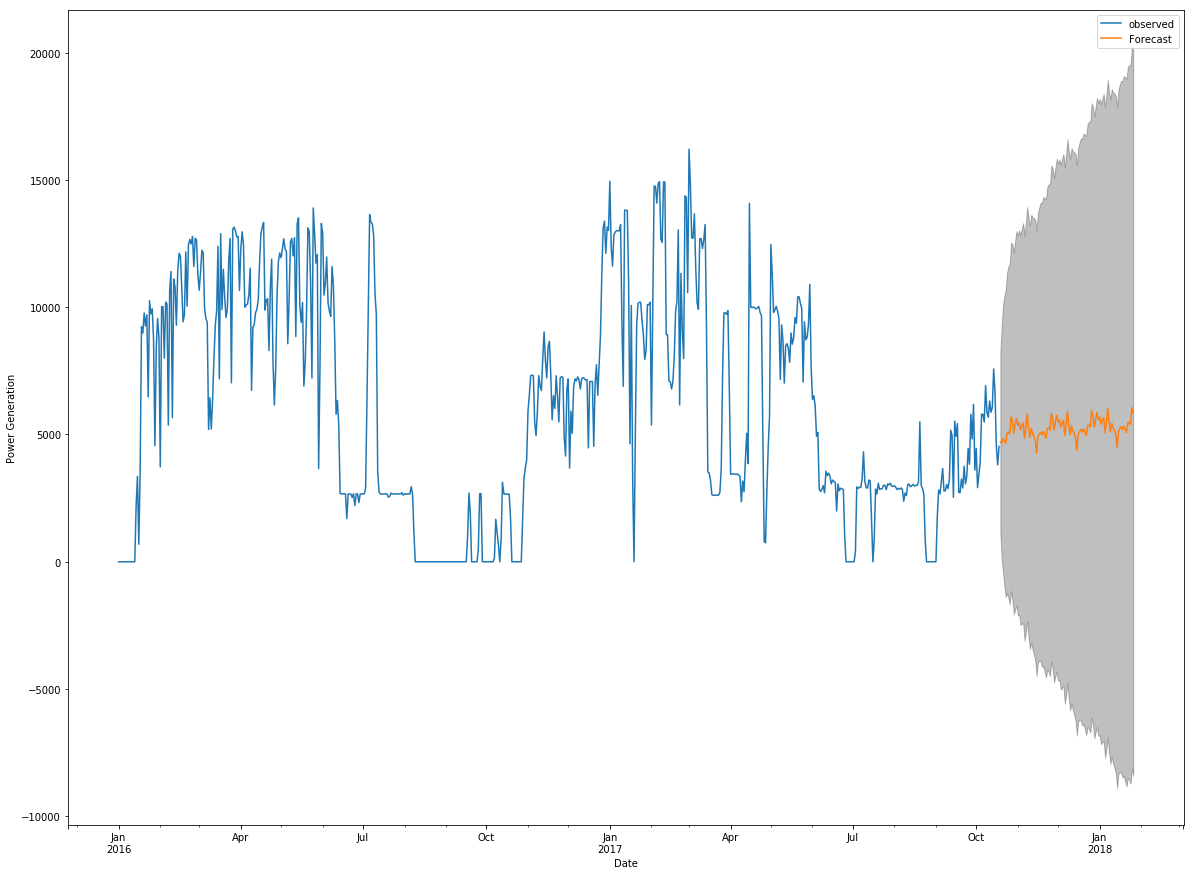

ALAOJI NIPP


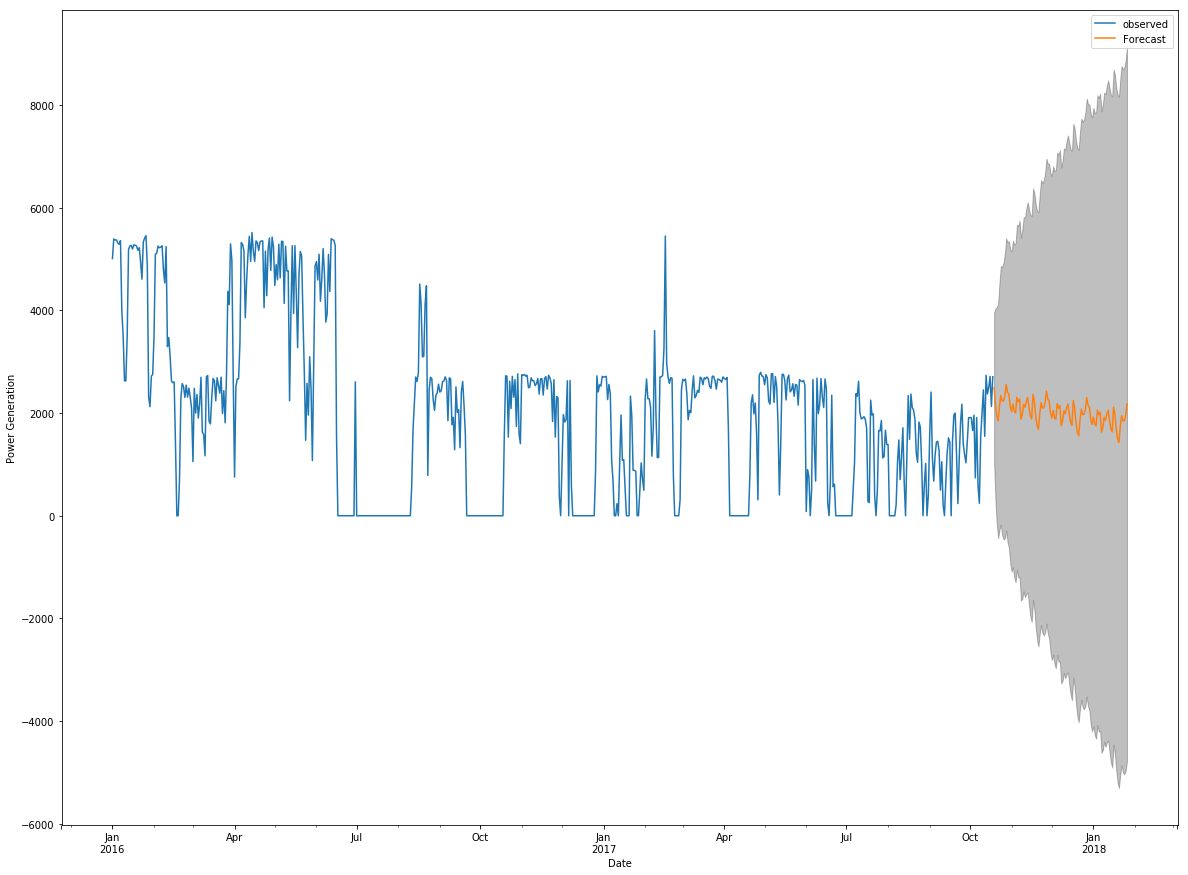

DELTA


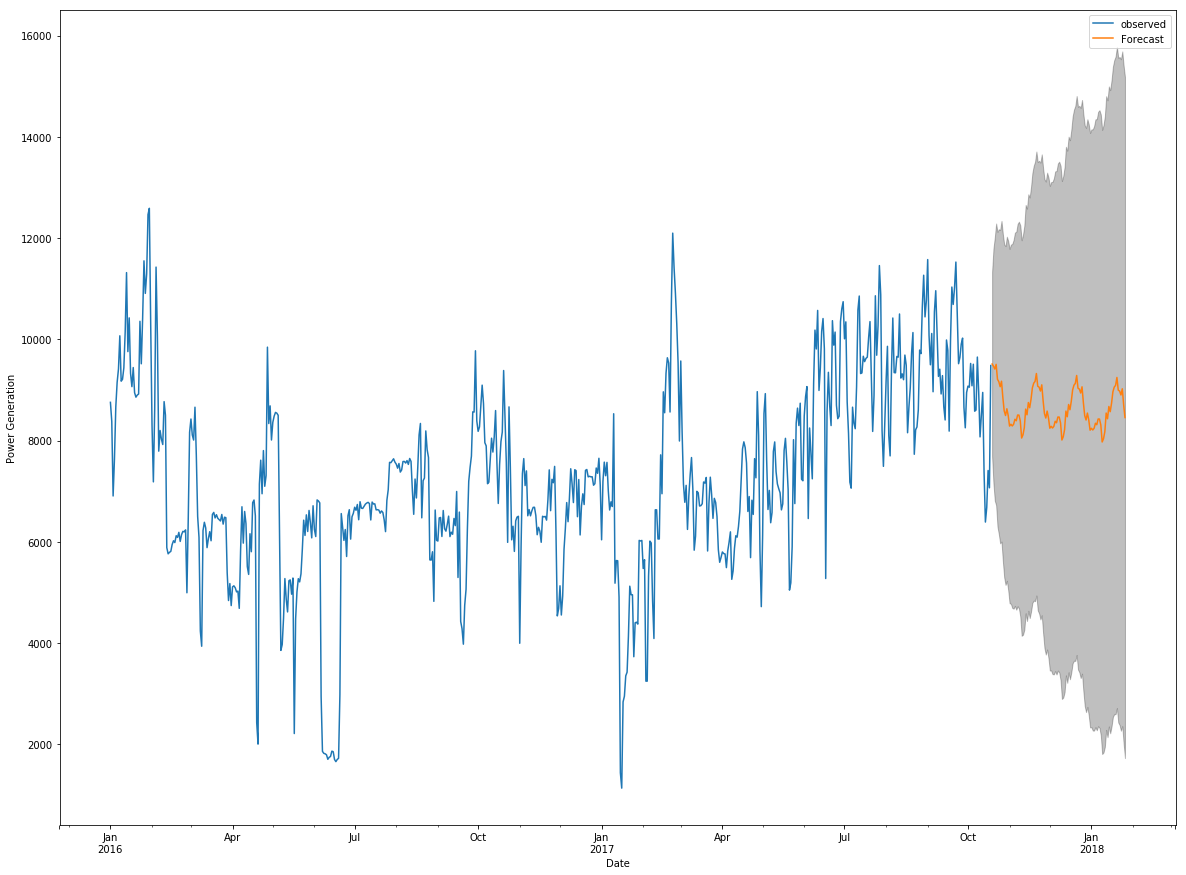

EGBIN


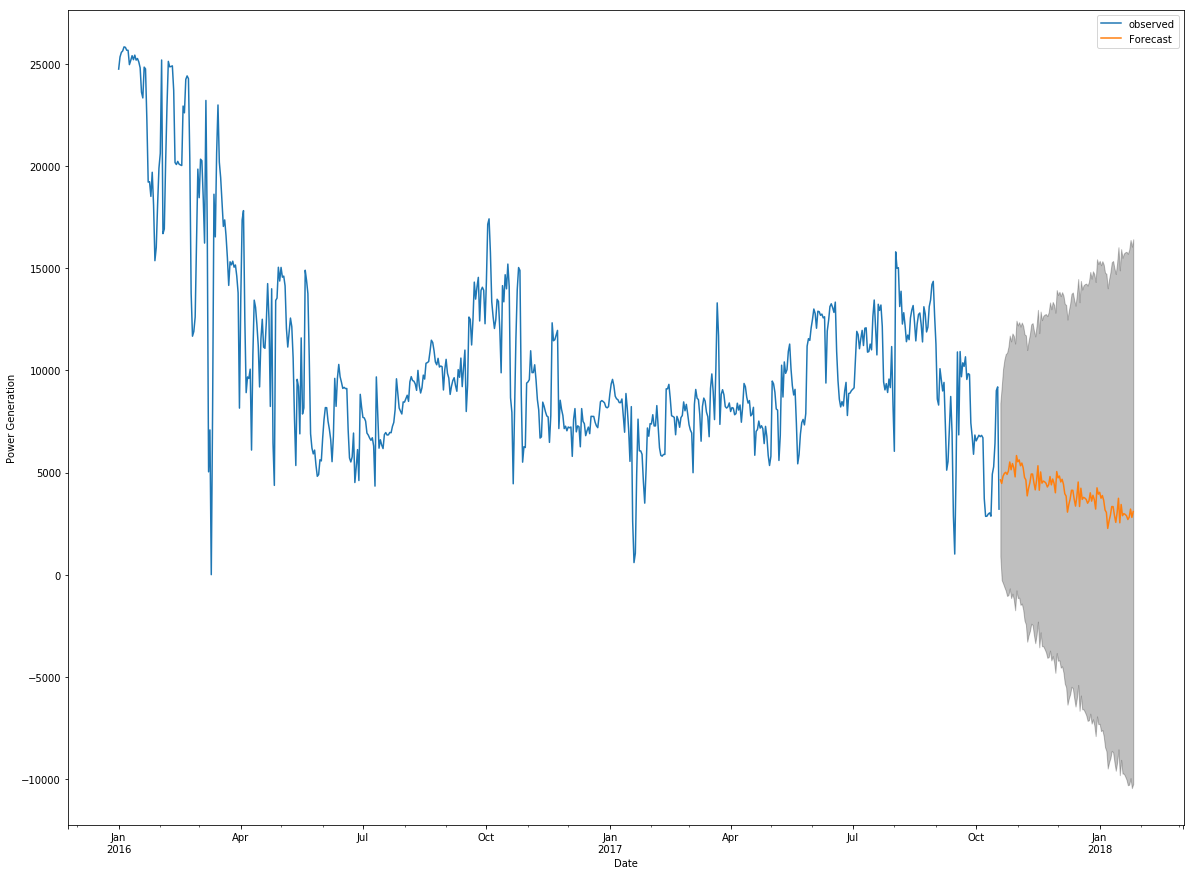

GEREGU


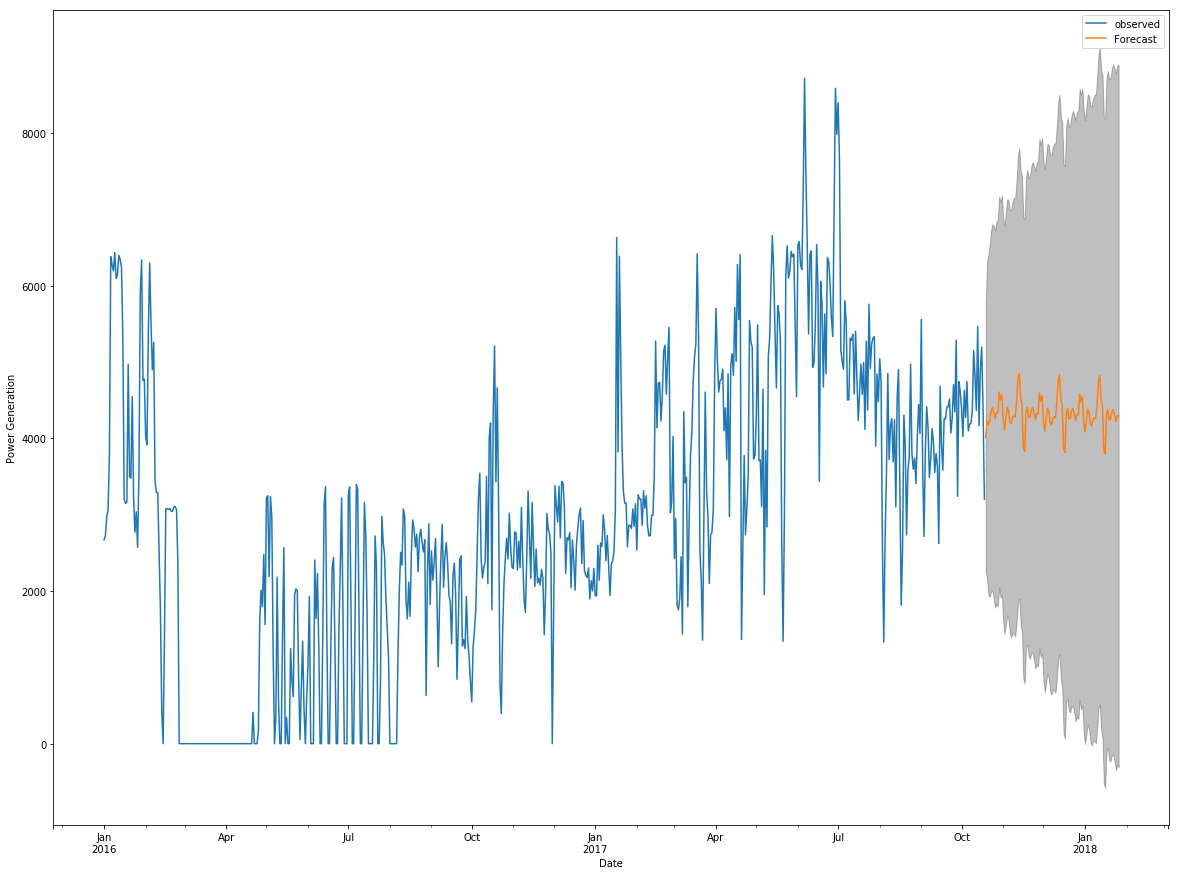

IBOM POWER


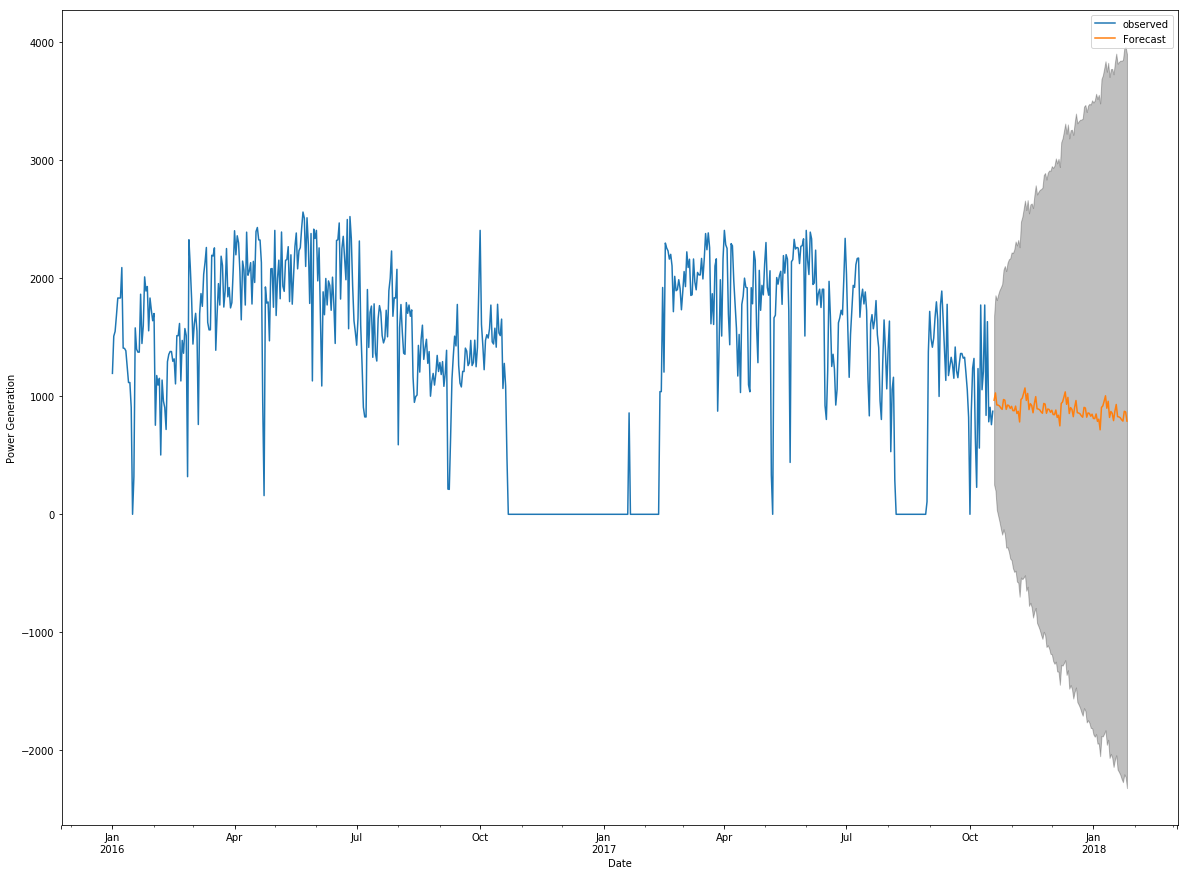

IHOVBOR NIPP


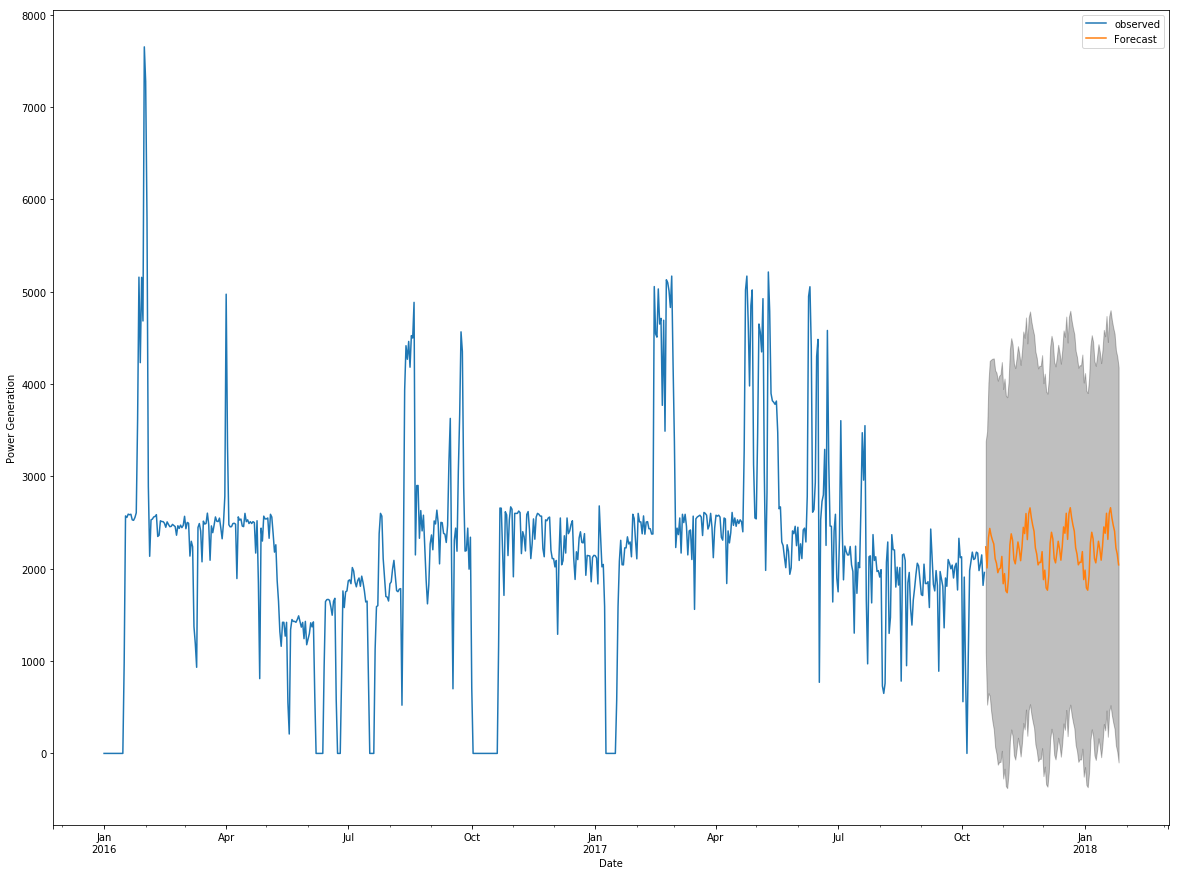

KAINJI


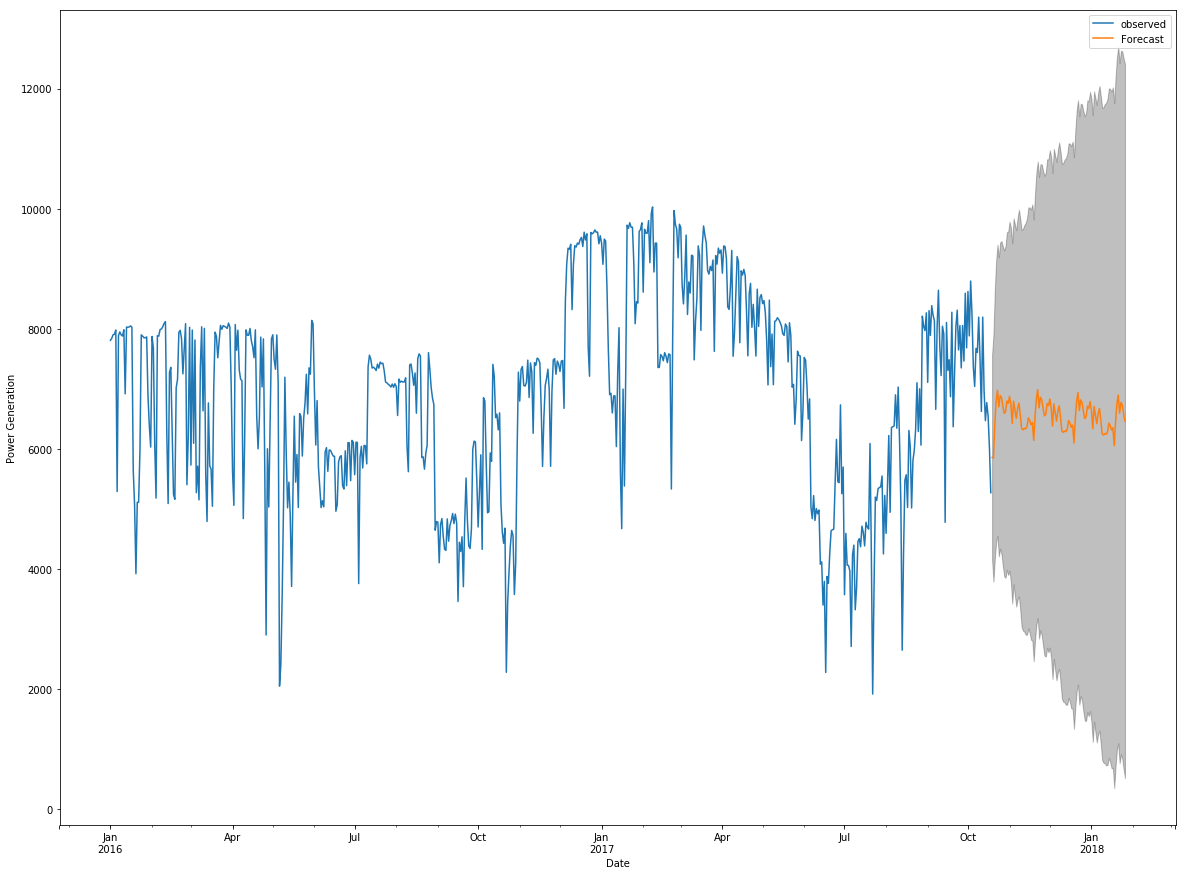

OLORUNSOGO


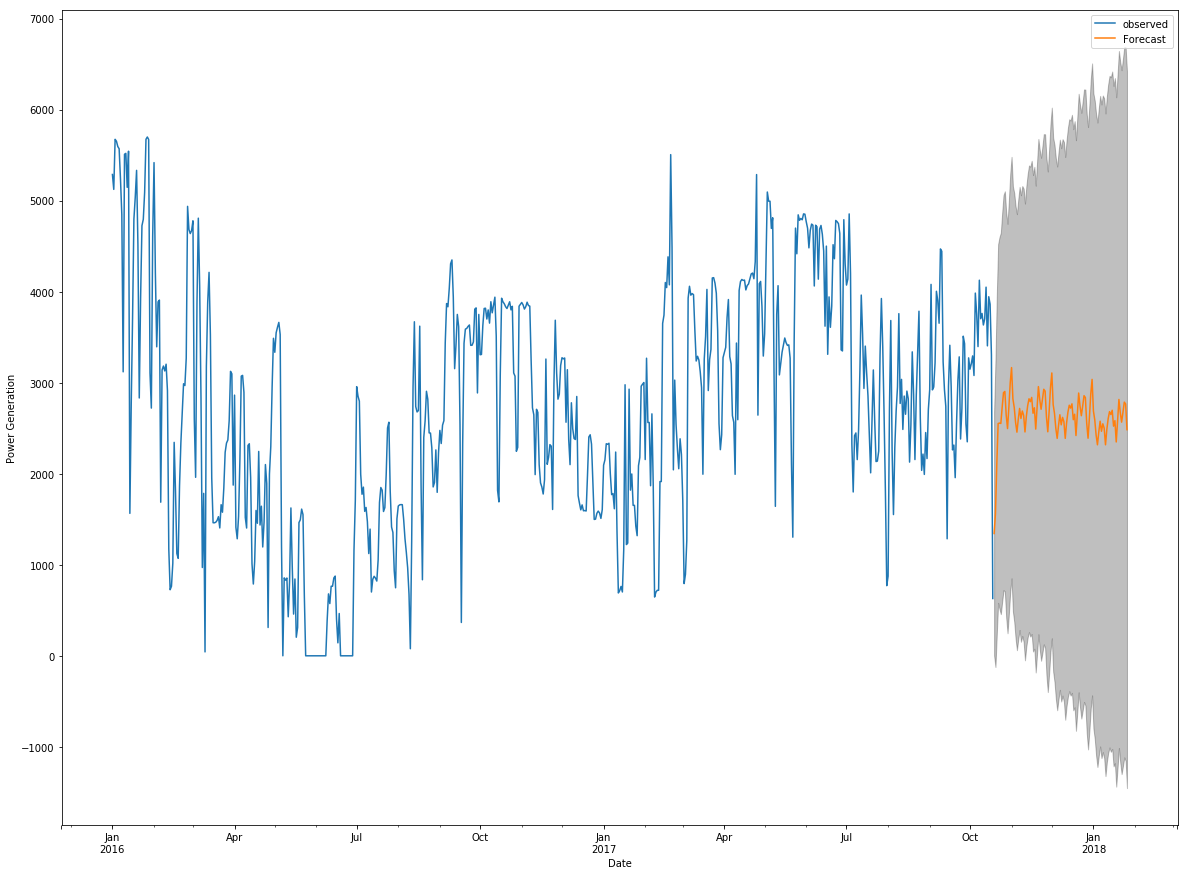

OLORUNSOGO NIPP


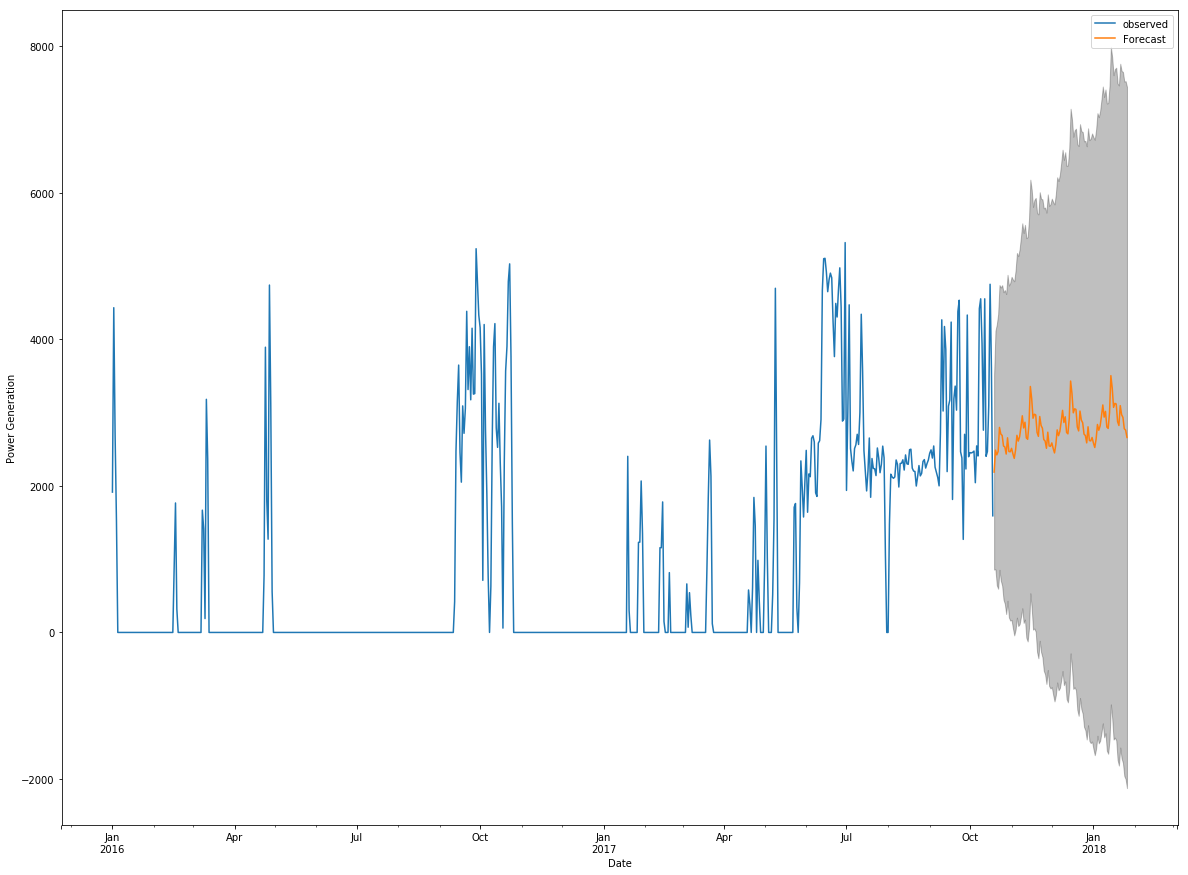

OMOKU


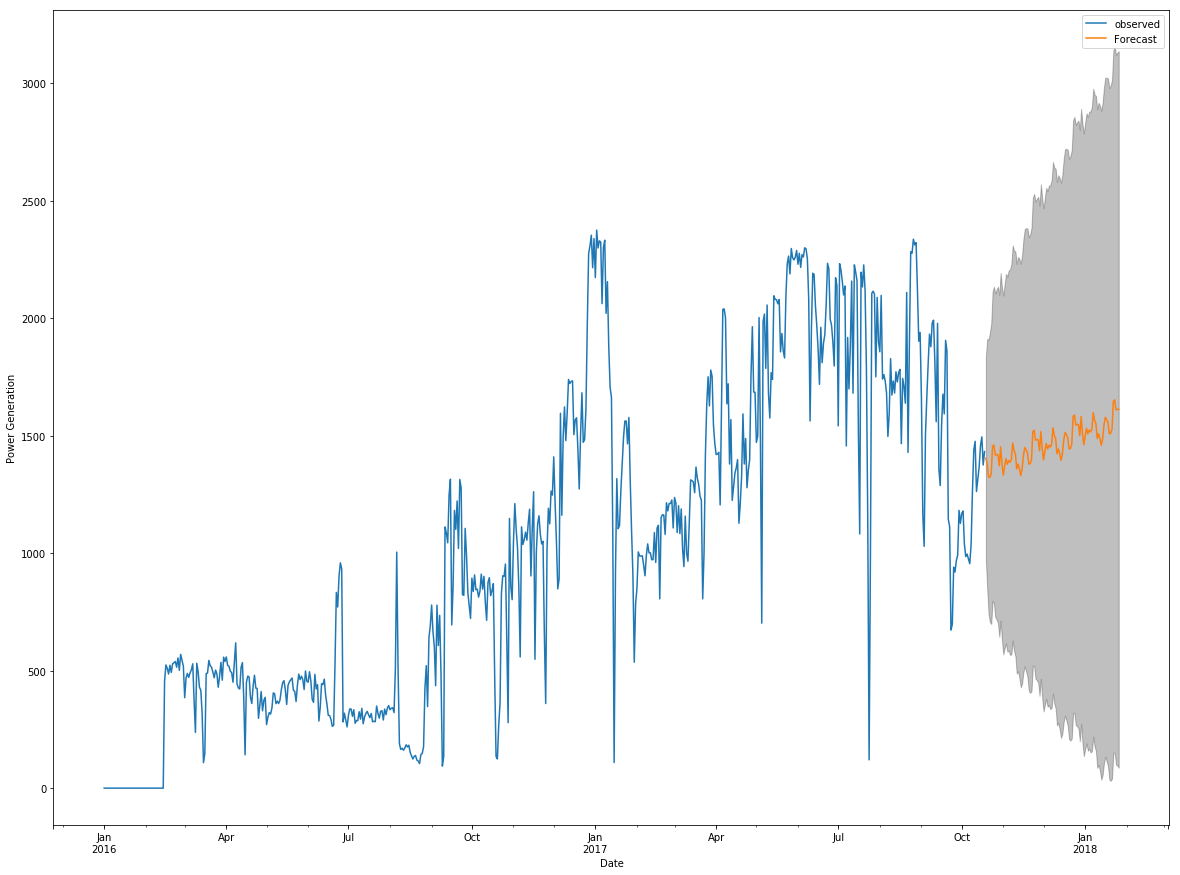

JEBBA


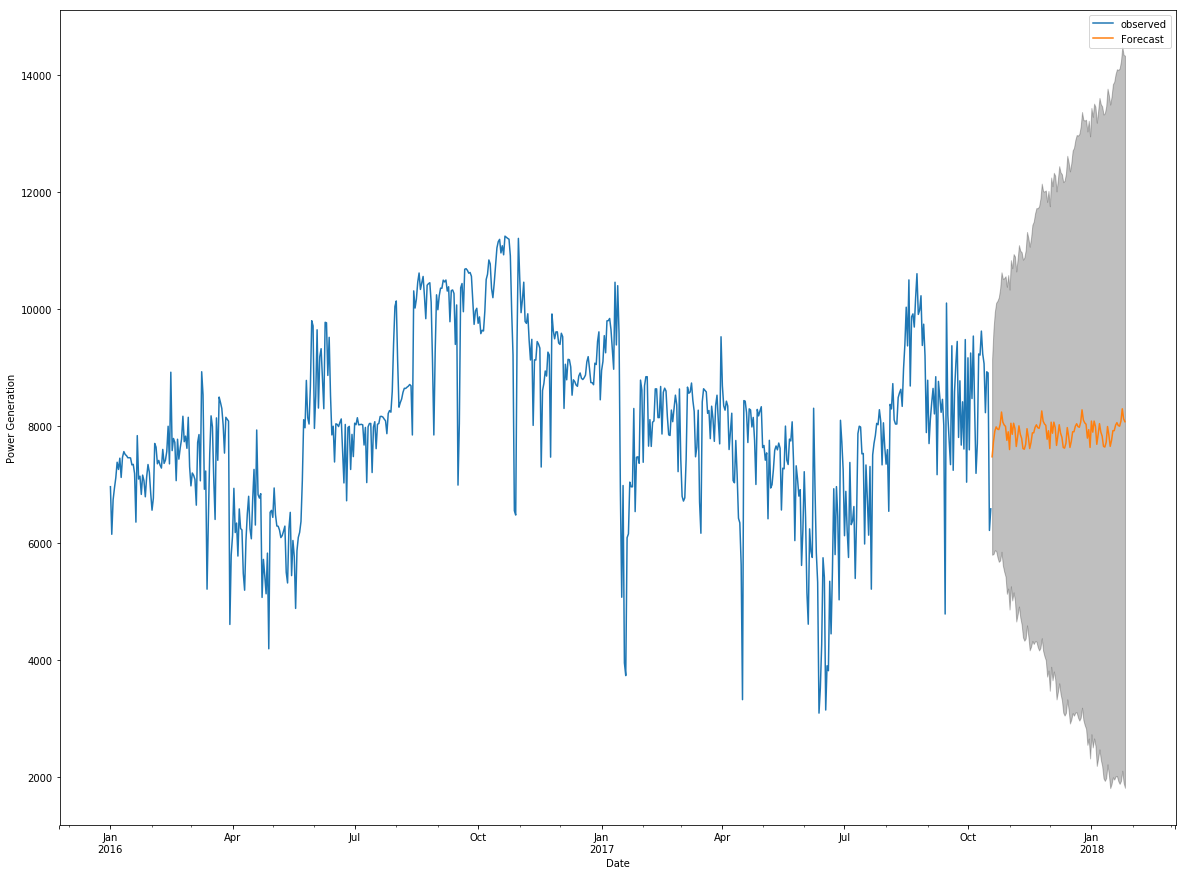

OMOTOSHO


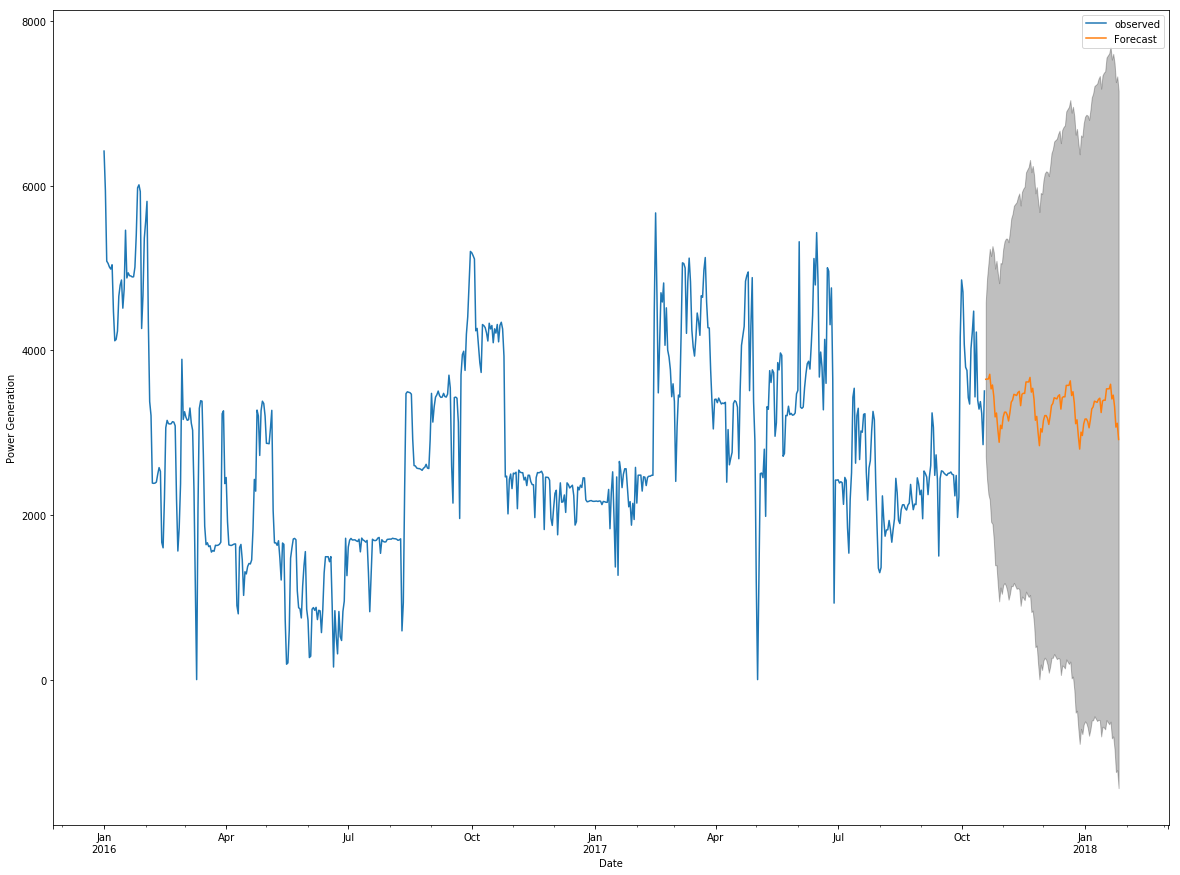

OMOTOSHO NIPP


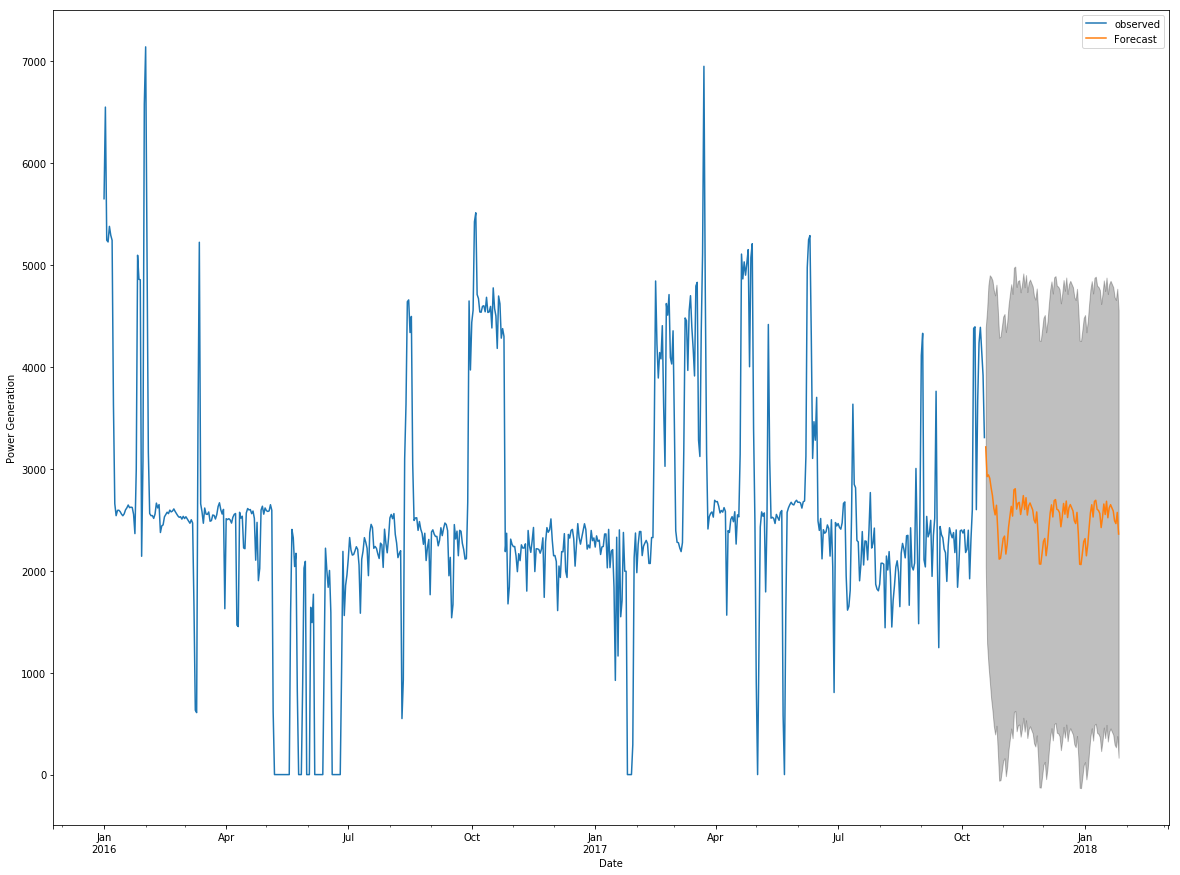

SAPELE NIPP


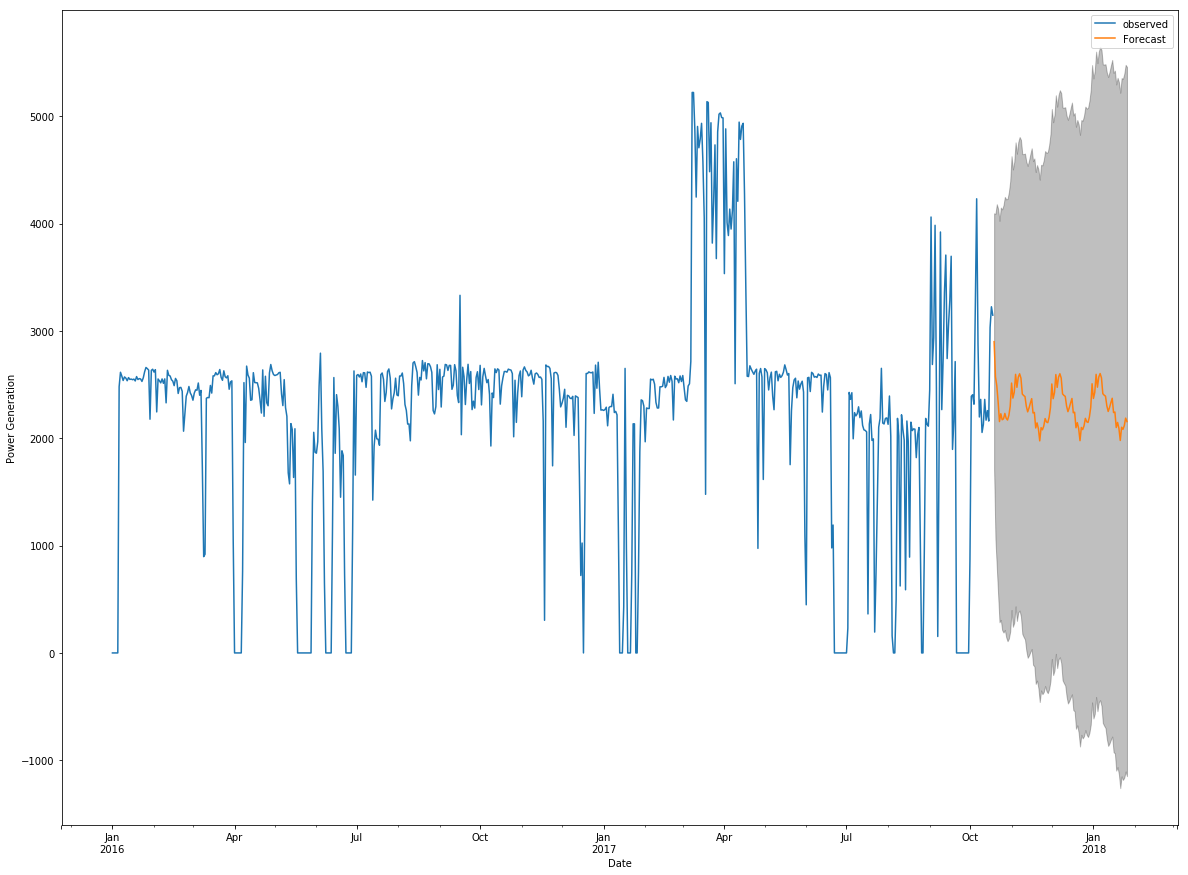

SHIRORO


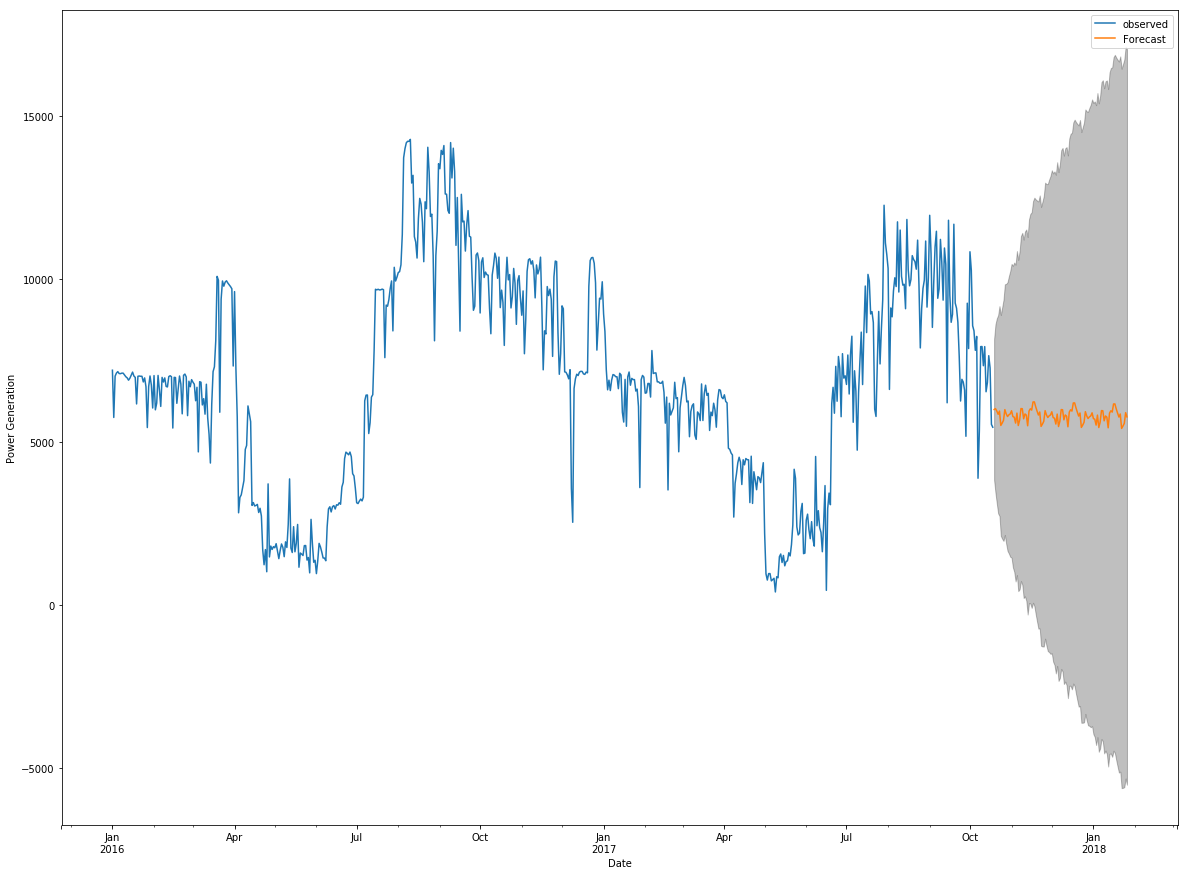

TRANS AMADI


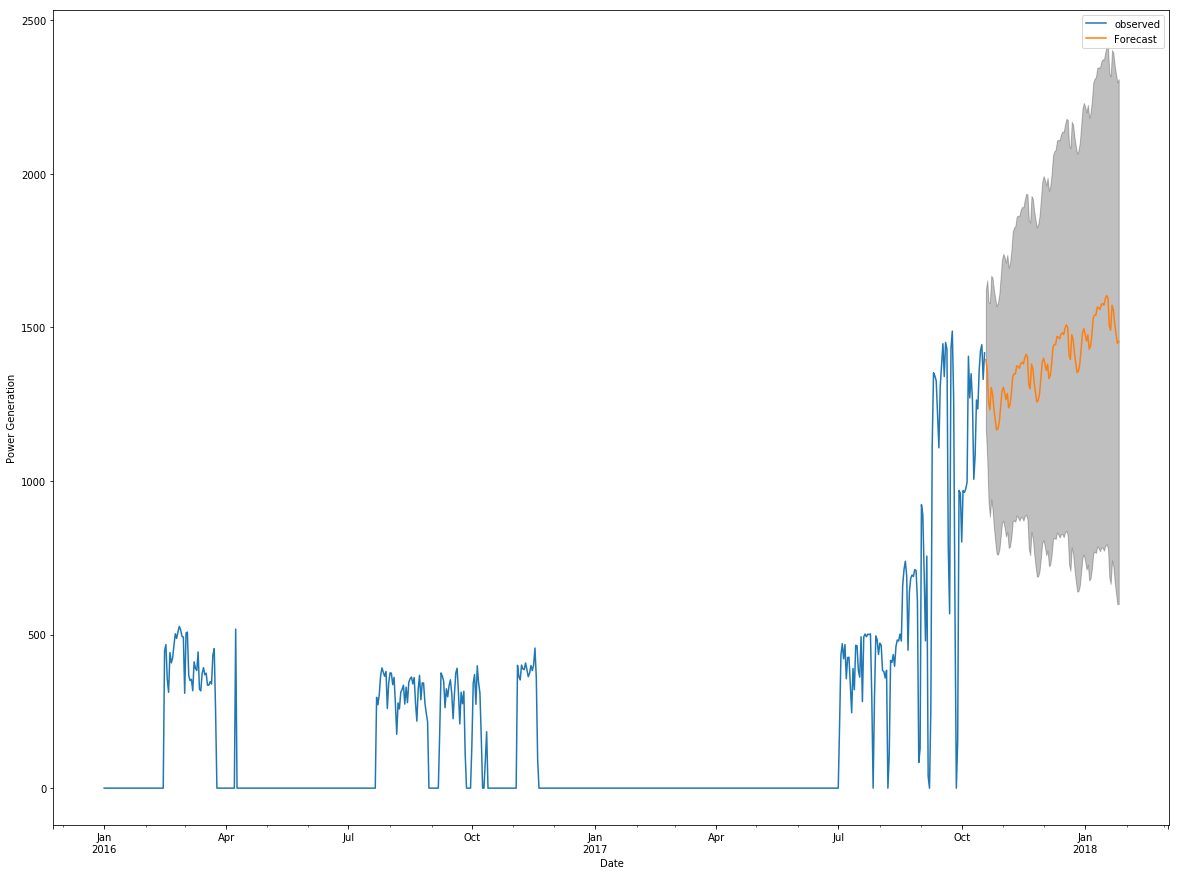

GBARAIN


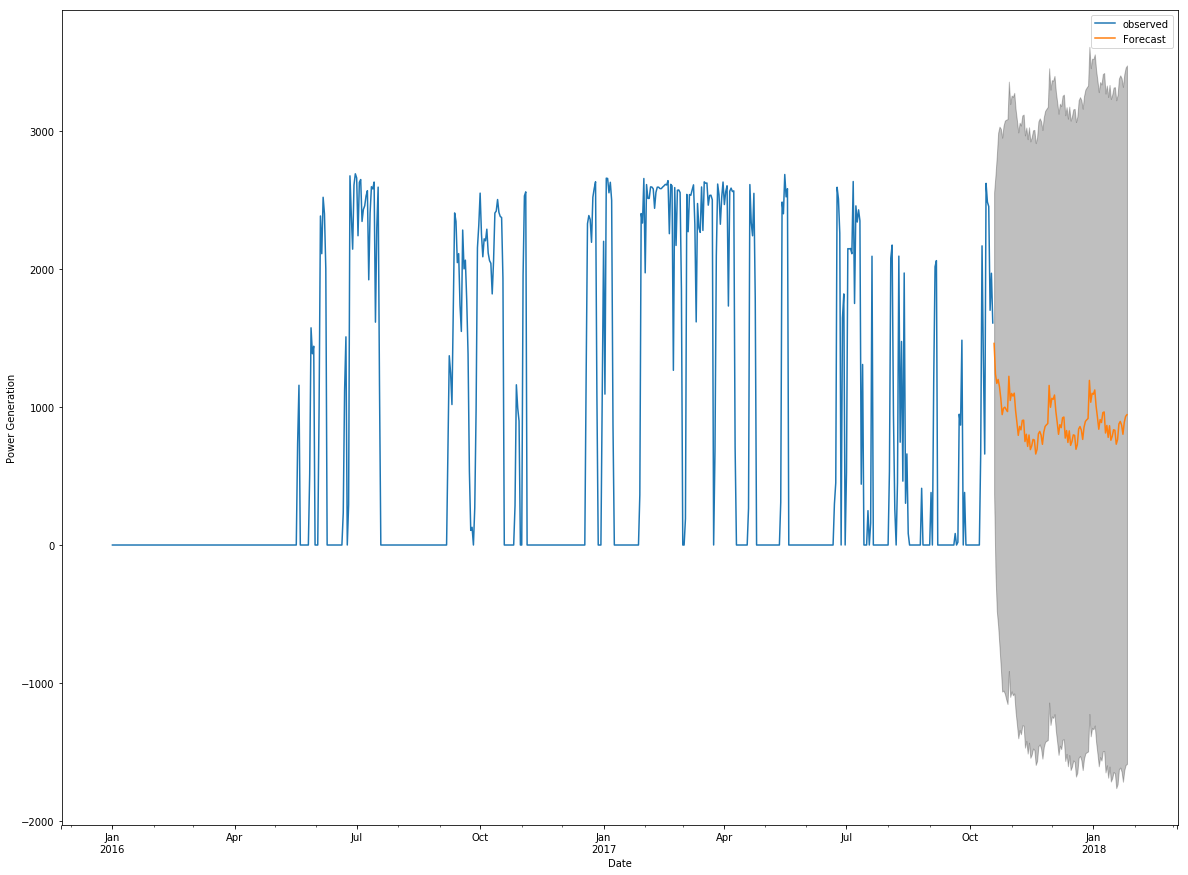

PARAS ENERGY


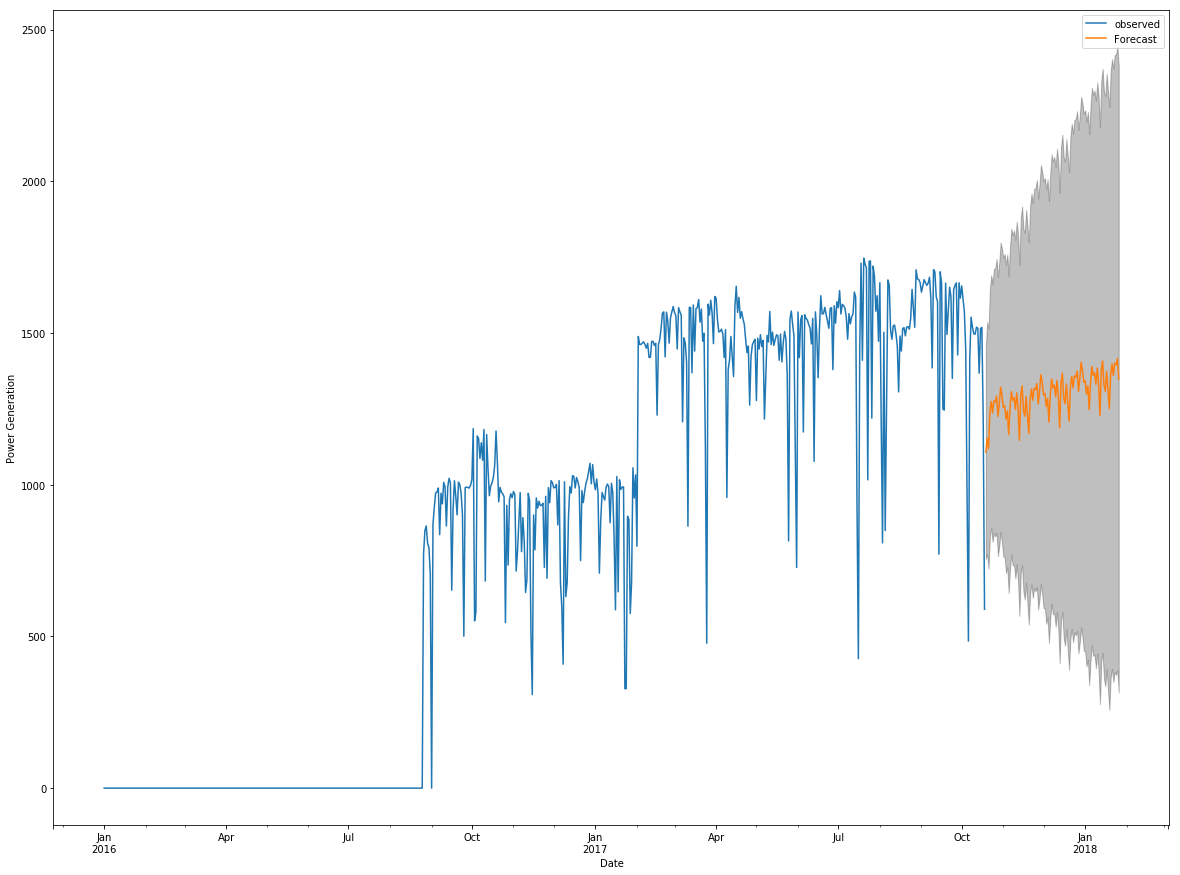

In [17]:
for genco, pred in predictions_final.items():
    print (genco)
    
    ax = power_gen[genco].plot(label='observed', figsize=(20, 15))
    pred[0].predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred[1].index,pred[1].iloc[:, 0],pred[1].iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Power Generation')

    plt.legend()
    plt.show()

In [24]:
power_predictions = pd.DataFrame(predictions_final.items(), index = pd.date_range(start ="20171019",end="20180126") )

ValueError: DataFrame constructor not properly called!

In [44]:
power_predictions = pd.DataFrame()
for genco, pred in predictions_final.items():
    
    power_predictions[genco] = pred[1].mean(axis=1)

In [45]:
power_predictions

AFAM VI  ALAOJI NIPP        DELTA        EGBIN       GEREGU  \
2017-10-19  4700.649416  2493.651038  9511.806032  4644.886935  4008.217029   
2017-10-20  4661.948560  2162.076107  9470.604262  4467.362613  4230.280492   
2017-10-21  4845.034957  1940.762090  9412.543229  4822.513927  4179.909586   
2017-10-22  4747.736077  1845.385706  9505.041024  4960.039379  4233.958083   
2017-10-23  4656.986854  2134.720610  9209.512773  5012.545113  4361.732572   
2017-10-24  5069.892443  2345.156231  9162.331528  4910.596375  4403.772420   
2017-10-25  5090.757106  2236.476775  9063.708649  5077.344758  4337.762677   
2017-10-26  5023.543990  2234.072437  9171.745278  5517.498283  4254.851841   
2017-10-27  5691.131919  2333.203982  8849.141120  5136.798803  4338.696892   
2017-10-28  5487.236094  2557.683544  8586.613058  5441.116993  4335.180674   
2017-10-29  5047.472682  2407.547922  8494.204914  5240.148353  4606.379500   
2017-10-30  5363.233192  2362.473438  8628.078569  4787.761580  4504.466800   
2017-10-31  5636.992162  2130.768336  8492.202133  5833.129598  4571.065426   
2017-11-01  5363.931340  2031.197200  8286.235839  5527.973655  4241.908311   
2017-11-02  5462.052045  2176.884374  8322.585822  5619.336344  4111.555311   
2017-11-03  5176.109390  2037.508197  8288.426463  5333.590088  4257.547473   
2017-11-04  5330.360734  2006.551726  8320.423896  5465.577275  4407.959045   
2017-11-05  5446.559988  2308.258308  8421.313220  5231.168865  4365.913801   
2017-11-06  4851.706746  2220.967159  8391.204397  4759.909073  4215.456347   
2017-11-07  5268.350066  2270.065709  8504.050945  4640.984019  4192.703556   
2017-11-08  5798.813386  1881.343945  8502.740499  3858.333047  4275.159135   
2017-11-09  5255.246807  1974.270052  8386.528551  4230.762331  4298.159438   
2017-11-10  4887.376683  2170.670872  8049.908461  4504.037204  4282.323665   
2017-11-11  5230.472722  2110.816680  8112.941564  4928.411329  4488.739410   
2017-11-12  5040.083596  2229.267450  8254.335977  4926.930486  4776.493450   
2017-11-13  4926.953132  2305.008168  8621.169840  4499.635339  4850.219708   
2017-11-14  4777.252431  2114.042816  8508.765763  4154.386758  4537.243877   
2017-11-15  4265.673890  1950.320484  8751.080197  4628.874552  4442.488935   
2017-11-16  4898.938285  1885.340498  8647.907006  5334.156656  3873.074236   
2017-11-17  5010.840277  2368.600415  8815.891780  4133.951469  3830.824784   
...                 ...          ...          ...          ...          ...   
2017-12-28  5283.519341  2153.051822  8405.745837  3673.977011  4578.558531   
2017-12-29  5595.104084  2108.599593  8542.894651  3212.964880  4476.270758   
2017-12-30  5865.703012  1877.296868  8409.277630  4252.410806  4542.664583   
2017-12-31  5590.250806  1777.985927  8204.870026  3943.188809  4213.395640   
2018-01-01  5686.561813  1923.841353  8242.295293  4031.759783  4082.981579   
2018-01-02  5399.249657  1784.573976  8208.877735  3744.096761  4228.940401   
2018-01-03  5552.464621  1753.687859  8241.386910  3874.767915  4379.333767   
2018-01-04  5667.879586  2055.439936  8342.629266  3639.455928  4337.278582   
2018-01-05  5072.432829  1968.178205  8312.763988  3167.575748  4186.815700   
2018-01-06  5488.627002  2017.295778  8425.778548  3048.224742  4164.059945   
2018-01-07  6018.750426  1628.586315  8424.584008  2265.281315  4246.513906   
2018-01-08  5474.926629  1721.520377  8308.452020  2637.509802  4269.513325   
2018-01-09  5106.861853  1917.926340  7971.887091  2910.646809  4253.677070   
2018-01-10  5449.810588  1858.075474  8034.958247  3334.926278  4460.092551   
2018-01-11  5259.309988  1976.528396  8176.378912  3333.380444  4747.846448   
2018-01-12  5146.095166  2052.270505  8543.230885  2906.040675  4821.572627   
2018-01-13  4996.330626  1861.306052  8430.839301  2560.761457  4508.596753   
2018-01-14  4484.703775  1697.584301  8673.162355  3035.228216  4413.841787   
2018-01-15  5117.931611  1632.604692  8569.995109  3740.495878  38

In [46]:
print (power_predictions.head())
print (power_predictions.info())
print (power_predictions.describe())
print (power_predictions.tail())

                AFAM VI  ALAOJI NIPP        DELTA        EGBIN       GEREGU  \
2017-10-19  4700.649416  2493.651038  9511.806032  4644.886935  4008.217029   
2017-10-20  4661.948560  2162.076107  9470.604262  4467.362613  4230.280492   
2017-10-21  4845.034957  1940.762090  9412.543229  4822.513927  4179.909586   
2017-10-22  4747.736077  1845.385706  9505.041024  4960.039379  4233.958083   
2017-10-23  4656.986854  2134.720610  9209.512773  5012.545113  4361.732572   

             IBOM POWER  IHOVBOR NIPP       KAINJI   OLORUNSOGO  \
2017-10-19   966.195282   2237.070712  5852.655570  1343.100929   
2017-10-20  1028.159182   2008.620932  5847.379202  1559.690767   
2017-10-21   926.389082   2334.394839  6405.395792  2101.382876   
2017-10-22   924.363489   2436.987545  6788.242883  2551.483590   
2017-10-23   917.619269   2361.373306  6974.158713  2556.488045   

            OLORUNSOGO NIPP        OMOKU        JEBBA     OMOTOSHO  \
2017-10-19      2187.579033  1403.967334  7477.00365

In [47]:
#Total power generated column added to the dataframe.
power_predictions['TOTAL'] = power_predictions.sum(axis=1)  


### Losses

We have compiled data showing the energy generated and sent out from 2015 to 2017 in excel. We used this data to compile the percentage losses everyday. We will use this to predict the losses up to 2020 and then apply this to our total power generated  

In [267]:
print (losses_data.head())
print (losses_data.info())
print (losses_data.describe())

                data
2015-01-01  0.018268
2015-01-02  0.021205
2015-01-03  0.023055
2015-01-04  0.029347
2015-01-05  0.022607
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2015-01-01 to 2017-12-31
Data columns (total 1 columns):
data    1096 non-null float64
dtypes: float64(1)
memory usage: 17.1 KB
None
              data
count  1096.000000
mean      0.018583
std       0.004048
min       0.005146
25%       0.015872
50%       0.018600
75%       0.020950
max       0.060764


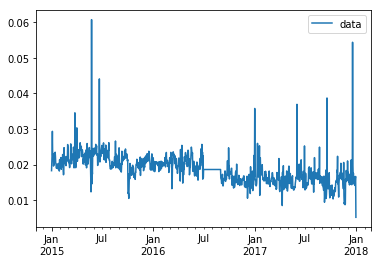

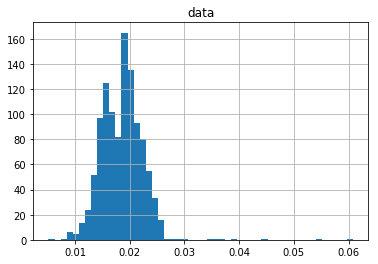

data    2.099006
dtype: float64

In [87]:
losses_data.plot()
plt.show()
losses_data.hist(bins=50)
plt.show()
losses_data.skew()

Holt Winters

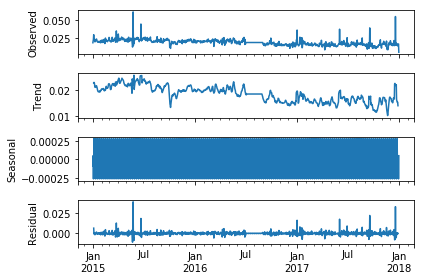

In [106]:

sm.tsa.seasonal_decompose(losses_data.data).plot()
result = sm.tsa.stattools.adfuller(losses_data.data)
plt.show()

num =  0.02
0.02
0.06076393300973343


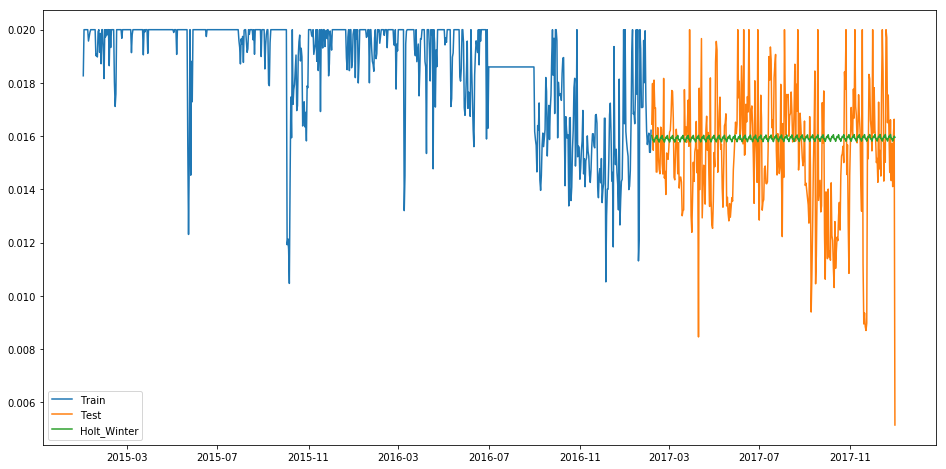

rms =  0.0023980353398839658
num =  0.021
0.021
0.06076393300973343


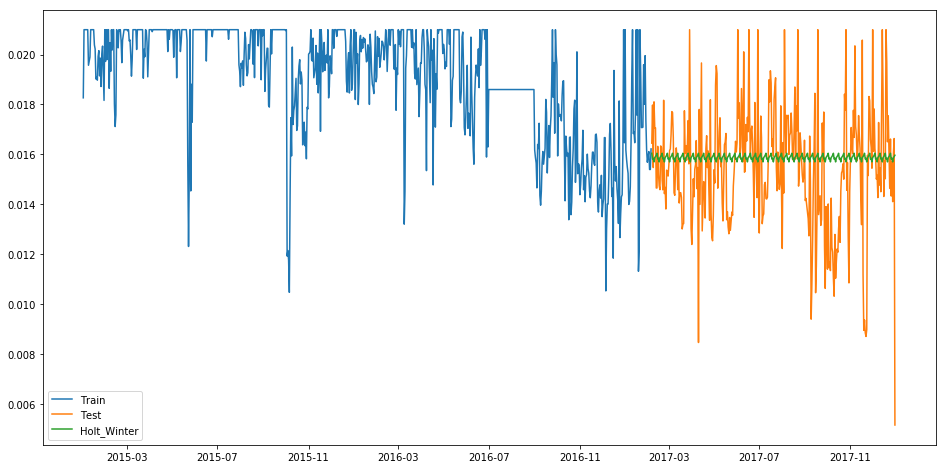

rms =  0.002460647034534692
num =  0.022000000000000002
0.022000000000000002
0.06076393300973343


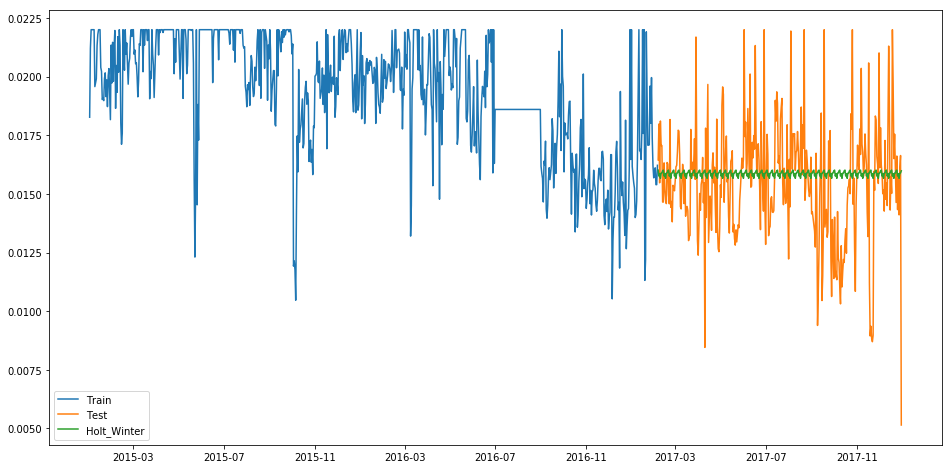

rms =  0.002515552839930455
num =  0.023000000000000003
0.023000000000000003
0.06076393300973343


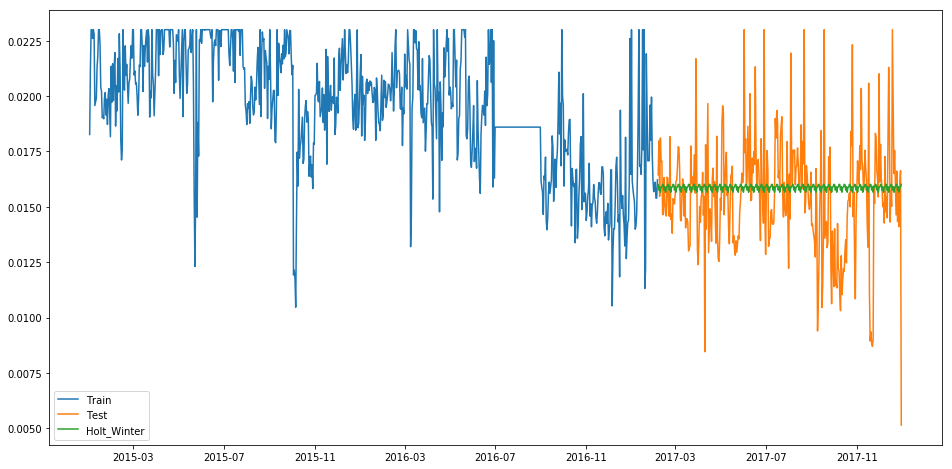

rms =  0.0025602671867082597
num =  0.024000000000000004
0.024000000000000004
0.06076393300973343


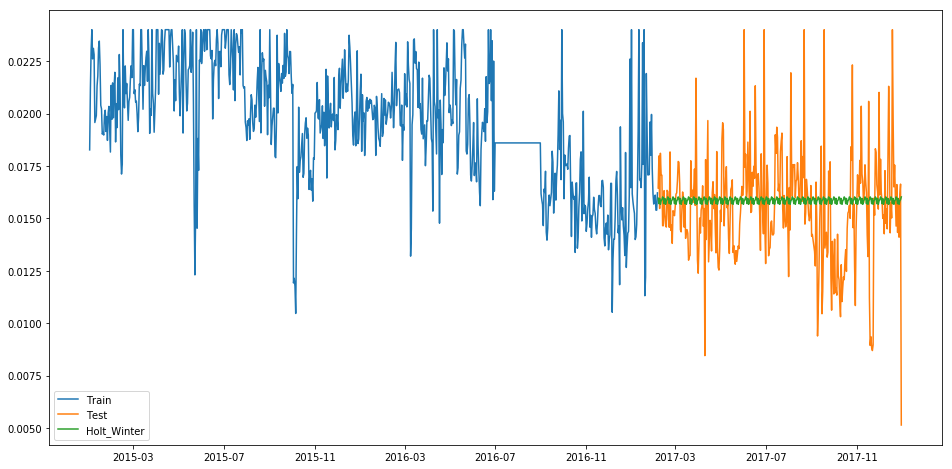

rms =  0.002605032741785715
num =  0.025000000000000005
0.025000000000000005
0.06076393300973343


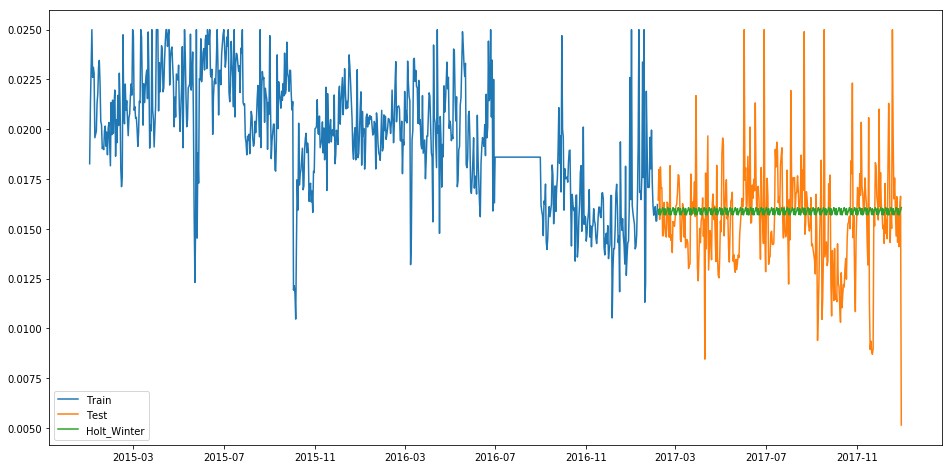

rms =  0.0026587792679317467
num =  0.026000000000000006
0.026000000000000006
0.06076393300973343


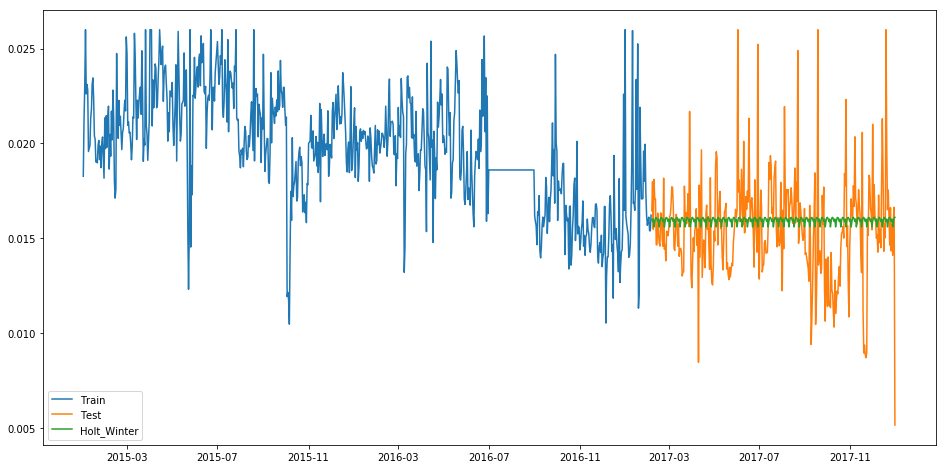

rms =  0.002706108572385972
num =  0.027000000000000007
0.027000000000000007
0.06076393300973343


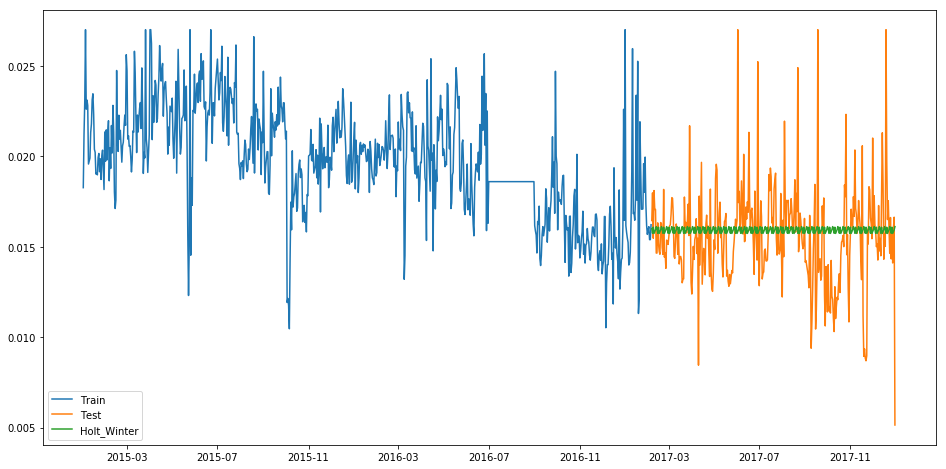

rms =  0.0027362820388940816
num =  0.028000000000000008
0.028000000000000008
0.06076393300973343


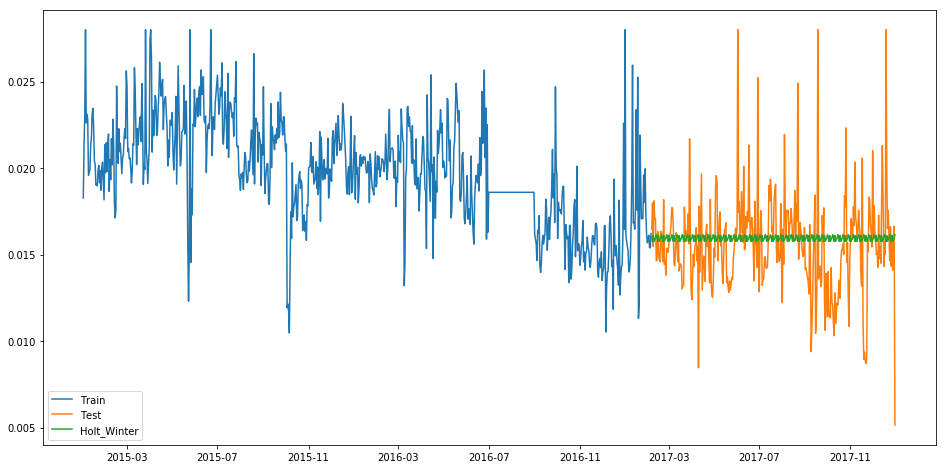

rms =  0.002778414768667158
num =  0.02900000000000001
0.02900000000000001
0.06076393300973343


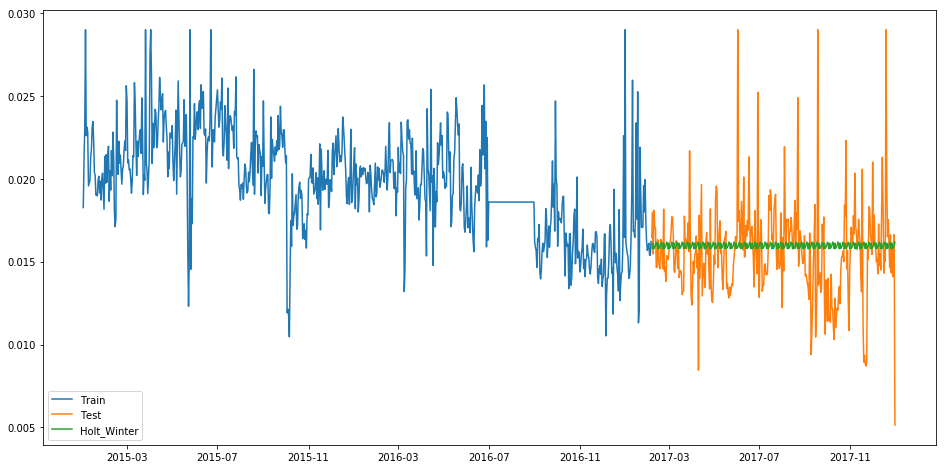

rms =  0.0028240028616583596
num =  0.03000000000000001
0.03000000000000001
0.06076393300973343


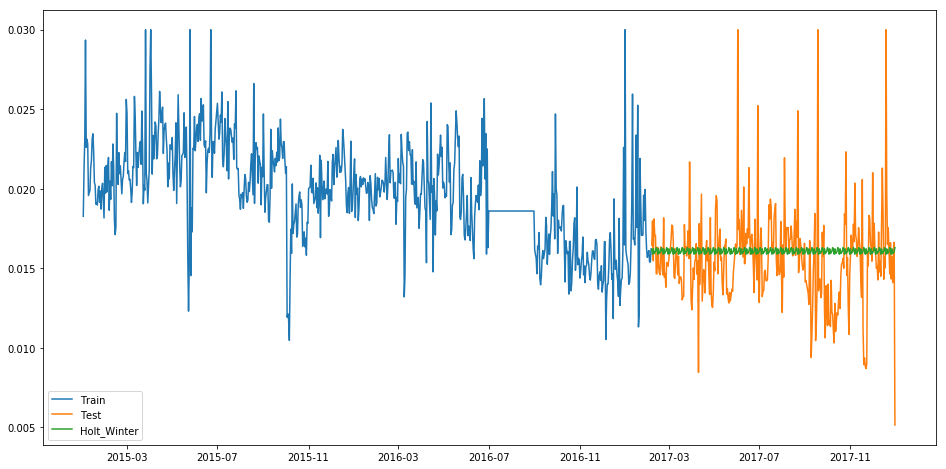

rms =  0.002885902508055817


In [193]:
num =0.02
for i in range(11):
    losses = losses_data.copy()
    print('num = ', num)
    
    for index, row in losses.iterrows():
        if losses.loc[index,'data'] > num: losses.loc[index,'data'] = num
    num +=0.001
    print(losses.data.max())
    print(losses_data.data.max())
        
        
    X = losses['data']
    size = int(len(X) * 0.7)

    train, test = X[0:size], X[size:len(X)]
    y_hat_avg = pd.DataFrame(test.copy())

    fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
    y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

    plt.figure(figsize=(16,8))
    plt.plot( train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
    plt.legend(loc='best')
    plt.show()

    rms = np.sqrt(mean_squared_error(test, y_hat_avg.Holt_Winter))
    print('rms = ', rms)

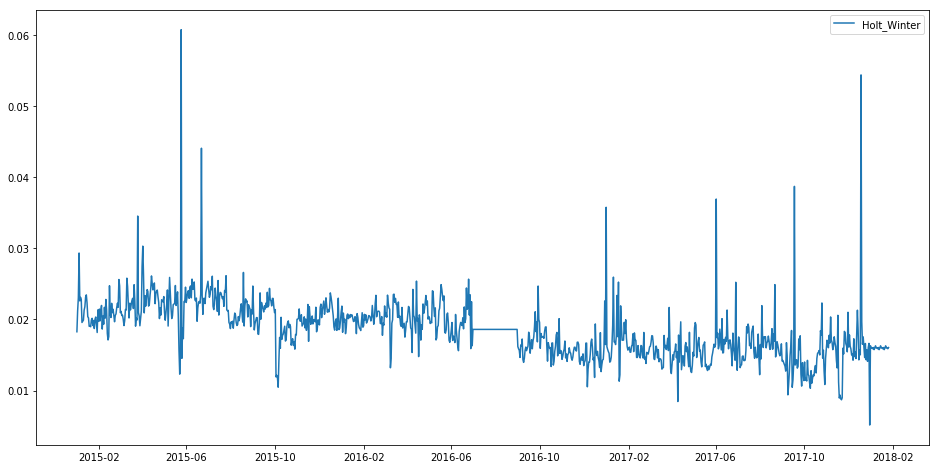

In [50]:
history = np.array(losses_data['data'])

fit1 = ExponentialSmoothing(np.asarray(history) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
pred = fit1.forecast(26)

pred_df = pd.DataFrame(index = pd.date_range(start ="20180101",end="20180126"))
pred_df['data'] = pred
losses_pred = pd.concat([losses_data,pred_df])


plt.figure(figsize=(16,8))
plt.plot(losses_pred['data'] , label='Holt_Winter')
plt.legend(loc='best')
plt.show()



In [51]:
print (losses_pred.head(4))
print (losses_pred.info())
print (losses_pred.tail(4))
print (losses_pred.describe())

                data
2015-01-01  0.018268
2015-01-02  0.021205
2015-01-03  0.023055
2015-01-04  0.029347
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1122 entries, 2015-01-01 to 2018-01-26
Data columns (total 1 columns):
data    1122 non-null float64
dtypes: float64(1)
memory usage: 17.5 KB
None
                data
2018-01-23  0.015985
2018-01-24  0.015998
2018-01-25  0.015879
2018-01-26  0.016051
              data
count  1122.000000
mean      0.018523
std       0.004020
min       0.005146
25%       0.015879
50%       0.018600
75%       0.020854
max       0.060764


Apply losses and convert from MWH to MW 

In [68]:
losses = losses_pred['2016':'2020']

total_power_sent_MW = power_predictions['TOTAL'] * (1-losses['data']) /24
total_power_sent_MW = pd.DataFrame(total_power_sent_MW)
total_power_sent_MW = total_power_sent_MW.dropna()
print (total_power_sent_MW.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2017-10-19 to 2018-01-26
Data columns (total 1 columns):
0    100 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB
None


In [69]:
total_power_sent_MW

0
2017-10-19  2732.657878
2017-10-20  2706.434710
2017-10-21  2757.419600
2017-10-22  2799.120061
2017-10-23  2809.092865
2017-10-24  2784.760135
2017-10-25  2783.842024
2017-10-26  2781.107357
2017-10-27  2815.385614
2017-10-28  2756.804814
2017-10-29  2724.292596
2017-10-30  2754.000397
2017-10-31  2802.628797
2017-11-01  2760.887765
2017-11-02  2755.834841
2017-11-03  2692.909926
2017-11-04  2731.178277
2017-11-05  2737.725911
2017-11-06  2682.214923
2017-11-07  2736.282397
2017-11-08  2752.460745
2017-11-09  2743.460551
2017-11-10  2699.585279
2017-11-11  2724.075175
2017-11-12  2733.916561
2017-11-13  2717.801543
2017-11-14  2704.389173
2017-11-15  2747.130946
2017-11-16  2773.412159
2017-11-17  2713.412274
...                 ...
2017-12-28  2655.979759
2017-12-29  2674.604770
2017-12-30  2732.305294
2017-12-31  2726.216388
2018-01-01  2694.615822
2018-01-02  2630.675064
2018-01-03  2668.570453
2018-01-04  2680.406459
2018-01-05  2623.152618
2018-01-06  2687.618614
2018-01-07  2693.152279
2018-01-08  2678.104310
2018-01-09  2632.275445
2018-01-10  2662.494589
2018-01-11  2673.669042
2018-01-12  2653.233091
2018-01-13  2638.468527
2018-01-14  2675.922606
2018-01-15  2699.380461
2018-01-16  2662.202283
2018-01-17  2765.664048
2018-01-18  2676.259434
2018-01-19  2694.295877
2018-01-20  2720.788015
2018-01-21  2719.793070
2018-01-22  2699.813363
2018-01-23  2695.222223
2018-01-24  2704.823097
2018-01-25  2716.663305
2018-01-26  2661.744647

[100 rows x 1 columns]

## Distribution Companies Invoice data

We also have invoices issued to DisCos for electricity sent to them. We will use this data to calculate the percentage of electricity sent to each DisCo from the total. Then, we can apply this percentages to our total of electricity distributed to estimate the amount of power each disco will receive on each day.

                   ABUJA         BENIN           EKO         ENUGU  \
2016-01-01  4.467545e+09  2.748026e+09  2.997902e+09  3.760045e+09   
2016-02-01  4.390058e+09  2.500902e+09  2.260301e+09  3.433329e+09   
2016-03-01  3.931829e+09  2.071696e+09  1.817907e+09  2.994063e+09   
2016-04-01  3.494490e+09  2.155452e+09  1.274058e+09  2.685962e+09   
2016-05-01  4.053909e+09  2.685688e+09  1.556787e+09  3.500154e+09   
2016-06-01  3.006621e+09  2.358437e+09  1.368708e+09  2.688096e+09   
2016-07-01  3.577627e+09  3.104913e+09  2.315013e+09  2.770086e+09   
2016-08-01  4.169235e+09  3.114114e+09  3.600815e+09  3.540771e+09   
2016-09-01  4.147421e+09  3.164246e+09  3.864053e+09  3.866221e+09   
2016-10-01  4.746591e+09  3.559696e+09  3.848188e+09  3.905410e+09   
2016-11-01  5.007589e+09  2.902188e+09  3.576168e+09  3.826918e+09   
2016-12-01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                  IBADAN         IKEJA           JOS        KADUNA  \
2016-01-01  3.57506

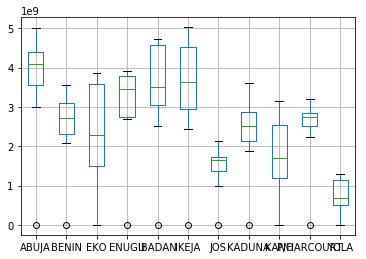

In [54]:
#Transpose to get a dat  e time index
discos_inv = discos_inv.transpose()
print (discos_inv.head(12))
print (discos_inv.info())
print (discos_inv.describe())


discos_inv.boxplot()

#create a totals column 
discos_inv['TOTAL'] = discos_inv.sum(axis=1)  
print (discos_inv.head())

#Build a list of DisCo names 
disco_names = (list(discos_inv.columns))

In [55]:
#Calculate percentage of total 
def percentage_of_totals(df):
    '''Takes a dataframe and returns anonother dataframe with a total column'''
    new_df = pd.DataFrame([])
    for disco in disco_names:
        if disco != 'TOTAL':
            new_df[disco]= (df[disco]/df['TOTAL'])*100
    return (new_df)            
disco_perc = percentage_of_totals(discos_inv)


In [56]:
#drop null values 
disco_perc = disco_perc.dropna() 
print(disco_perc)

                ABUJA      BENIN        EKO      ENUGU     IBADAN      IKEJA  \
2016-01-01  13.779158   8.475679   9.246366  11.597031  11.026507  13.367315   
2016-02-01  15.633328   8.905902   8.049105  12.226343  11.011601  11.874457   
2016-03-01  15.639616   8.240573   7.231080  11.909469  11.583213  11.593535   
2016-04-01  16.103062   9.932599   5.871025  12.377260  11.586266  11.184288   
2016-05-01  15.097194  10.001790   5.797642  13.034949  12.738545  11.977977   
2016-06-01  13.341565  10.465315   6.073496  11.928142  14.136275  13.186658   
2016-07-01  12.217323  10.603043   7.905592   9.459633  13.682976  13.375471   
2016-08-01  11.936967   8.916041  10.309519  10.137606  13.538344  14.394534   
2016-09-01  11.363560   8.669751  10.587159  10.593098  12.719085  13.774142   
2016-10-01  12.461384   9.345389  10.102775  10.253002  11.955082  12.702052   
2016-11-01  14.115292   8.180629  10.080431  10.787241  13.046293  12.494957   

                 JOS    KADUNA      KAN

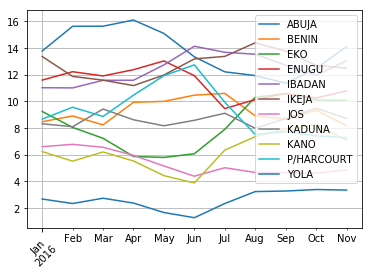

In [57]:
#plot
disco_perc.plot(grid=True)
plt.xticks(rotation=45)
plt.show()
#disco_perc.plot(y=['ABUJA','EKO','P/HARCOURT'], grid=True)
#plt.show()

In [73]:
# Calculate mean and median 
disco_mean = disco_perc.mean(axis=1)
disco_median = disco_perc.median(axis=0)
print (disco_median)


ABUJA         13.779158
BENIN          8.916041
EKO            8.049105
ENUGU         11.597031
IBADAN        12.719085
IKEJA         12.702052
JOS            5.023350
KADUNA         8.621392
KANO           6.237003
P/HARCOURT     8.871566
YOLA           2.678286
dtype: float64


In [74]:
disco_med =  disco_median/100
print (disco_med)

ABUJA         0.137792
BENIN         0.089160
EKO           0.080491
ENUGU         0.115970
IBADAN        0.127191
IKEJA         0.127021
JOS           0.050233
KADUNA        0.086214
KANO          0.062370
P/HARCOURT    0.088716
YOLA          0.026783
dtype: float64


In [75]:
transposed_disco_formula = pd.DataFrame(disco_med).T
total_power_sent_MW = pd.DataFrame(total_power_sent_MW)
print (total_power_sent_MW.shape) 
print (transposed_disco_formula.shape)


print (total_power_sent_MW.info()) 
print (transposed_disco_formula.info())
disco_per_day = total_power_sent_MW.dot(transposed_disco_formula) 

(100, 1)
(1, 11)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2017-10-19 to 2018-01-26
Data columns (total 1 columns):
0    100 non-null float64
dtypes: float64(1)
memory usage: 1.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
ABUJA         1 non-null float64
BENIN         1 non-null float64
EKO           1 non-null float64
ENUGU         1 non-null float64
IBADAN        1 non-null float64
IKEJA         1 non-null float64
JOS           1 non-null float64
KADUNA        1 non-null float64
KANO          1 non-null float64
P/HARCOURT    1 non-null float64
YOLA          1 non-null float64
dtypes: float64(11)
memory usage: 168.0 bytes
None


In [77]:
print(disco_per_day)

                 ABUJA       BENIN         EKO       ENUGU      IBADAN  \
2017-10-19  376.537253  243.644910  219.954491  316.907168  347.569065   
2017-10-20  372.923922  241.306841  217.843760  313.866059  344.233718   
2017-10-21  379.949210  245.852675  221.947587  319.778793  350.718530   
2017-10-22  385.695183  249.570705  225.304101  324.614808  356.022447   
2017-10-23  387.069351  250.459885  226.106823  325.771357  357.290896   
2017-10-24  383.716506  248.290369  224.148256  322.949483  354.195996   
2017-10-25  383.589998  248.208509  224.074356  322.843009  354.079220   
2017-10-26  383.213184  247.964685  223.854240  322.525869  353.731396   
2017-10-27  387.936439  251.020949  226.613333  326.501129  358.091276   
2017-10-28  379.864498  245.797860  221.898103  319.707496  350.640335   
2017-10-29  375.384588  242.899058  219.281160  315.937044  346.505078   
2017-10-30  379.478073  245.547817  221.672372  319.382267  350.283638   
2017-10-31  386.178657  249.883546  22

No handles with labels found to put in legend.


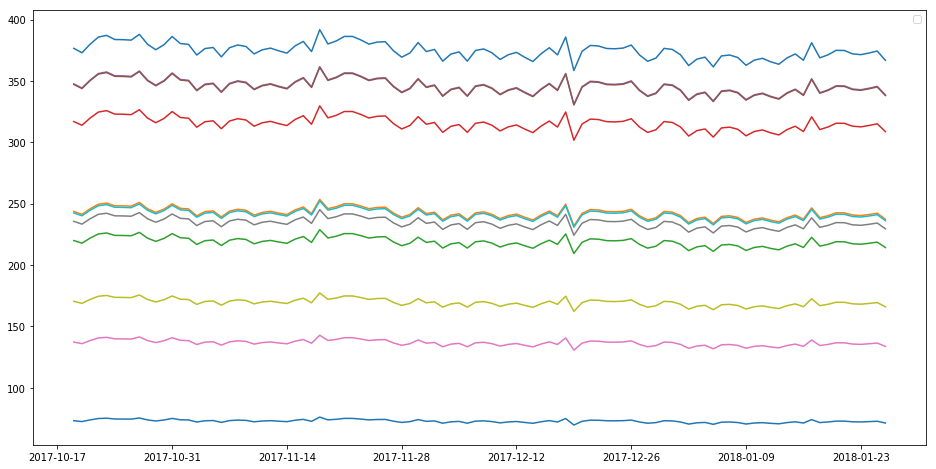

In [78]:
plt.figure(figsize=(16,8))
plt.plot(disco_per_day)
plt.legend(loc='best')
plt.show()
